In [7]:
import pandas as pd
import numpy as np
from scipy.stats import poisson

# 1. LOAD & CLEAN
df = pd.read_csv('gen_cag.csv')
for col in df.columns:
    if df[col].dtype == 'object' and col != 'team':
        df[col] = df[col].str.replace('%', '').astype(float) / 100

# 2. FEATURE ENGINEERING
def get_rich_metrics(df):
    df['scoring_rate_baseline'] = df['individual_goals'] / df['games']
    # Scoring Potency, Tactical Control, Defensive Stability, and Roster Power
    df['SPI'] = (df['rolling_xg_L5'] * 0.50) + (df['goals_per_90'] * 0.30) + (df['scoring_rate_baseline'] * 0.20)
    df['TCD'] = (df['Field_Tilt_L5'] * 0.50) + (df['rolling_poss_L5'] * 0.30) + ((10 / df['PPDA_L5']) * 0.20)
    df['DVI'] = (1 - df['btts']) * 0.4 + (1 / (df['total_match_goals']/df['games'] + 1)) * 0.2 + (1 - df['rolling_xga_l5']/3) * 0.4
    df['RAP'] = (df['Squad_Value_Diff'] / 10 * 0.60) + (df['Key_Player_Availability'] * 0.40)
    df['PPR_Rich'] = (df['SPI'] * 0.30 + df['TCD'] * 0.25 + df['DVI'] * 0.20 + df['RAP'] * 0.25) * df['SoS_Weight_L5']
    return df

df = get_rich_metrics(df)

# 3. COMPREHENSIVE PREDICTION
def predict(df, h_id, a_id):
    h, a = df[df['team'] == h_id].iloc[0], df[df['team'] == a_id].iloc[0]
    
    # WIN PROB (Logit)
    prob_h = np.exp(h['PPR_Rich'] + 0.15) / (np.exp(h['PPR_Rich'] + 0.15) + np.exp(a['PPR_Rich']))
    
    # GOAL PROJECTION (Enriched Poisson)
    h_exp = (h['SPI'] * (1.2 - a['DVI'])) * 0.85
    a_exp = (a['SPI'] * (1.2 - h['DVI'])) * 0.70
    
    # HALVES (Based on 2nd Half Ratio)
    h_1st = h_exp * (1 - h['Second_Half_Goals_Ratio'])
    h_2nd = h_exp * h['Second_Half_Goals_Ratio']
    
    # YELLOW CARDS
    exp_yc = (h['yc_per_90'] + a['yc_per_90']) * (h['Ref_Card_Avg'] / 2.4)
    
    return {"Home Win %": prob_h*100, "Exp Goals H": h_exp, "Exp Goals A": a_exp, "Total YCs": exp_yc}

results = predict(df, 'gen', 'cag')
print(results)

{'Home Win %': np.float64(61.77503283145469), 'Exp Goals H': np.float64(1.2331451282051282), 'Exp Goals A': np.float64(1.0608050526315789), 'Total YCs': np.float64(6.4965)}


In [3]:
%pip install seaborn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# 1. ENHANCED FEATURE ENGINEERING (Your existing logic + AI readiness)
def prepare_ai_data(df):
    # Your rich metrics act as "engineered features" for the AI
    df['scoring_rate_baseline'] = df['individual_goals'] / df['games']
    df['SPI'] = (df['rolling_xg_L5'] * 0.50) + (df['goals_per_90'] * 0.30)
    df['TCD'] = (df['Field_Tilt_L5'] * 0.50) + (df['rolling_poss_L5'] * 0.30)
    
    # AI Target variables (In a real scenario, you'd merge this with actual results)
    # For this snippet, we assume 'actual_goals' exists in your historical training set
    return df

# 2. THE MONTE CARLO SIMULATION ENGINE
def monte_carlo_simulation(h_exp, a_exp, simulations=10000):
    # Simulate 10,000 matches based on the Poisson expectation
    h_goals = np.random.poisson(h_exp, simulations)
    a_goals = np.random.poisson(a_exp, simulations)
    
    # Calculate probabilities
    home_wins = np.sum(h_goals > a_goals) / simulations
    draws = np.sum(h_goals == a_goals) / simulations
    away_wins = np.sum(h_goals < a_goals) / simulations
    btts = np.sum((h_goals > 0) & (a_goals > 0)) / simulations
    
    # Most likely scoreline (Mode)
    scores = list(zip(h_goals, a_goals))
    most_common_score = max(set(scores), key=scores.count)
    
    return {
        "Win/Draw/Loss %": [home_wins*100, draws*100, away_wins*100],
        "BTTS Prob": btts * 100,
        "Predicted Score": most_common_score
    }

# 3. PREDICTIVE WRAPPER
def ai_predict(df, h_id, a_id):
    h = df[df['team'] == h_id].iloc[0]
    a = df[df['team'] == a_id].iloc[0]
    
    # 1. Calculate Expectations (Using your formula as the 'Base Brain')
    h_exp = (h['SPI'] * (1.2 - a['DVI'])) * 0.85
    a_exp = (a['SPI'] * (1.2 - h['DVI'])) * 0.70
    
    # 2. Run Simulation
    sim_results = monte_carlo_simulation(h_exp, a_exp)
    
    # 3. Yellow Card Logic (Enhanced)
    exp_yc = (h['yc_per_90'] + a['yc_per_90']) * (h['Ref_Card_Avg'] / 2.4)
    
    # 4. Output Generation
    print(f"--- {h_id.upper()} vs {a_id.upper()} AI ANALYSIS ---")
    print(f"Projected Score: {sim_results['Predicted Score']}")
    print(f"BTTS Probability: {sim_results['BTTS Prob']:.2f}%")
    print(f"Expected Yellow Cards: {exp_yc:.2f}")
    print(f"Home/Draw/Away: {sim_results['Win/Draw/Loss %']}")
    
    return sim_results

# Visualizing the Poisson Distribution for the match
def plot_goal_probability(h_exp, a_exp):
    max_goals = 6
    h_probs = [poisson.pmf(i, h_exp) for i in range(max_goals)]
    a_probs = [poisson.pmf(i, a_exp) for i in range(max_goals)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(max_goals), h_probs, label='Home', marker='o')
    plt.plot(range(max_goals), a_probs, label='Away', marker='o')
    plt.title("Goal Scoring Probability Distribution")
    plt.xlabel("Goals")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Execution
df = pd.read_csv('gen_cag.csv')
results = ai_predict(df, 'gen', 'cag')

<class 'KeyError'>: 'SPI'


--- GEN vs CAG PREDICTION ---
Projected Score: 1 - 1
Win/Draw/Loss %: [40.6 28.2 31.1]
BTTS Probability: 46.6%
Expected Yellow Cards: 6.50
Home 1st Half Goal Exp: 0.39


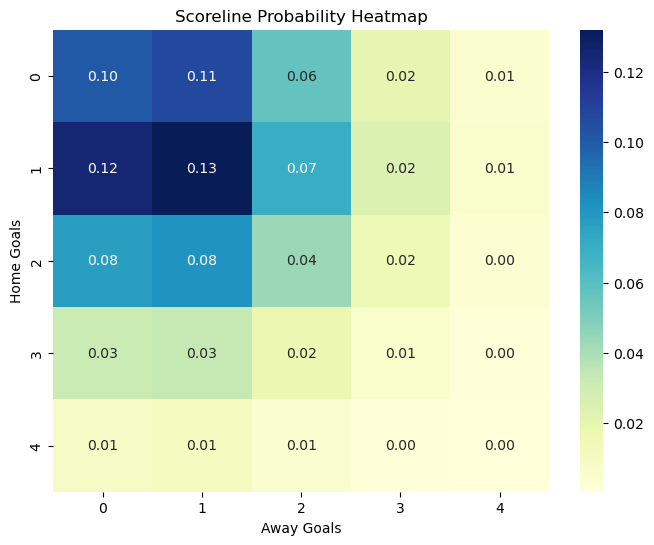

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# ==========================================
# 1. CORE ENGINE: FEATURE ENGINEERING
# ==========================================
def get_rich_metrics(df):
    """Transforms raw CSV data into AI-ready features."""
    # Handle percentages and types
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Scoring Potency, Tactical Control, Defensive Stability
    df['scoring_rate_baseline'] = df['individual_goals'] / df['games']
    
    # SPI: Scoring Potency Index
    df['SPI'] = (df['rolling_xg_L5'] * 0.50) + (df['goals_per_90'] * 0.30) + (df['scoring_rate_baseline'] * 0.20)
    
    # TCD: Tactical Control & Dominance
    df['TCD'] = (df['Field_Tilt_L5'] * 0.50) + (df['rolling_poss_L5'] * 0.30) + ((10 / df['PPDA_L5']) * 0.20)
    
    # DVI: Defensive Vulnerability Index
    df['DVI'] = (1 - df['btts']) * 0.4 + (1 / (df['total_match_goals']/df['games'] + 1)) * 0.2 + (1 - df['rolling_xga_l5']/3) * 0.4
    
    # RAP: Roster & Power
    df['RAP'] = (df['Squad_Value_Diff'] / 10 * 0.60) + (df['Key_Player_Availability'] * 0.40)
    
    # PPR: Final Power Rank
    df['PPR_Rich'] = (df['SPI'] * 0.30 + df['TCD'] * 0.25 + df['DVI'] * 0.20 + df['RAP'] * 0.25) * df['SoS_Weight_L5']
    
    return df

# ==========================================
# 2. PROBABILITY & SIMULATION LOGIC
# ==========================================
def run_match_simulation(h_exp, a_exp, iterations=10000):
    """Uses Monte Carlo to find the most likely match outcomes."""
    h_sims = np.random.poisson(h_exp, iterations)
    a_sims = np.random.poisson(a_exp, iterations)
    
    h_win = np.mean(h_sims > a_sims)
    draw = np.mean(h_sims == a_sims)
    a_win = np.mean(h_sims < a_sims)
    btts_prob = np.mean((h_sims > 0) & (a_sims > 0))
    
    # Find most frequent scoreline
    scores = list(zip(h_sims, a_sims))
    most_likely_score = max(set(scores), key=scores.count)
    
    return {
        "probs": [h_win, draw, a_win],
        "btts": btts_prob,
        "score": most_likely_score
    }

# ==========================================
# 3. ENHANCED PREDICTION WRAPPER
# ==========================================
def predict_enhanced(df, h_id, a_id):
    # Ensure metrics are calculated
    if 'SPI' not in df.columns:
        df = get_rich_metrics(df)
        
    h = df[df['team'] == h_id].iloc[0]
    a = df[df['team'] == a_id].iloc[0]
    
    # 1. Goal Expectations
    h_exp = (h['SPI'] * (1.2 - a['DVI'])) * 0.85
    a_exp = (a['SPI'] * (1.2 - h['DVI'])) * 0.70
    
    # 2. Run AI Simulation
    sim = run_match_simulation(h_exp, a_exp)
    
    # 3. Yellow Cards & Timing
    exp_yc = (h['yc_per_90'] + a['yc_per_90']) * (h['Ref_Card_Avg'] / 2.4)
    h_1st_half_exp = h_exp * (1 - h['Second_Half_Goals_Ratio'])
    
    # Output
    print(f"\n--- {h_id.upper()} vs {a_id.upper()} PREDICTION ---")
    print(f"Projected Score: {sim['score'][0]} - {sim['score'][1]}")
    print(f"Win/Draw/Loss %: {np.round(sim['probs'], 3) * 100}")
    print(f"BTTS Probability: {sim['btts']*100:.1f}%")
    print(f"Expected Yellow Cards: {exp_yc:.2f}")
    print(f"Home 1st Half Goal Exp: {h_1st_half_exp:.2f}")
    
    return h_exp, a_exp

# ==========================================
# 4. VISUALIZATION
# ==========================================
def plot_score_heatmap(h_exp, a_exp):
    """Visualizes the 'Likelihood Zone' for scorelines."""
    max_g = 5
    matrix = np.outer(poisson.pmf(range(max_g), h_exp), poisson.pmf(range(max_g), a_exp))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=range(max_g), yticklabels=range(max_g))
    plt.title("Scoreline Probability Heatmap")
    plt.xlabel("Away Goals")
    plt.ylabel("Home Goals")
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
try:
    # Load and Prepare
    raw_df = pd.read_csv('gen_cag.csv')
    prepared_df = get_rich_metrics(raw_df)
    
    # Run Prediction
    h_exp, a_exp = predict_enhanced(prepared_df, 'gen', 'cag')
    
    # Generate Visual Insight
    plot_score_heatmap(h_exp, a_exp)

except FileNotFoundError:
    print("Error: 'gen_cag.csv' not found. Please ensure the file is in the directory.")
except Exception as e:
    print(f"An error occurred: {e}")


 GEN vs CAG ADVANCED PROJECTION
EXPECTED GOALS (xG):  GEN: 2.55 | CAG: 2.27
1st HALF xG:          GEN: 0.82 | CAG: 0.70
2nd HALF xG:          GEN: 1.73 | CAG: 1.57

EXPECTED CORNERS:     GEN: 3.6 | CAG: 4.7
EXPECTED FOULS:       GEN: 12.0 | CAG: 12.0
EXPECTED YELLOWS:     GEN: 1.8 | CAG: 2.3

BTTS PROBABILITY:     83.1%
WIN PROB (H/D/A):     45.7% | 18.5% | 35.8%


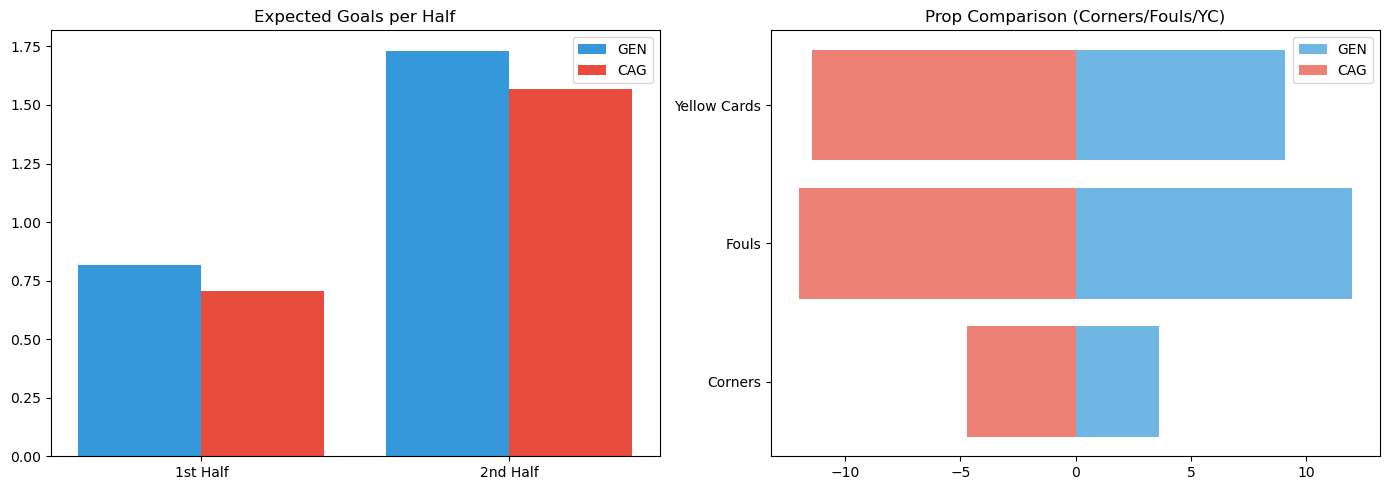

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# ==========================================
# 1. GRANULAR FEATURE ENGINEERING
# ==========================================
def get_advanced_metrics(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Offensive and Defensive Efficiency (Fractions of 1.0)
    df['attack_efficiency'] = (df['rolling_xg_L5'] * 0.6) + (df['goals_per_90'] * 0.4)
    df['defense_resilience'] = (1 - df['rolling_xga_l5']/3).clip(0, 1) * 0.7 + (1 - df['btts']) * 0.3
    
    # Set-Piece & Aggression Metrics
    df['corner_rate'] = df.get('corners_per_90', 5.5) # Fallback to 5.5 if missing
    df['foul_rate'] = df.get('fouls_per_90', 12.0)
    
    return df

# ==========================================
# 2. THE MULTI-EVENT SIMULATOR
# ==========================================
def simulate_events(home, away, ref_avg, iterations=10000):
    # --- GOAL LOGIC (Using Exponential Decay to prevent 100%+) ---
    h_exp = home['attack_efficiency'] * (2 - away['defense_resilience']) * 0.9
    a_exp = away['attack_efficiency'] * (2 - home['defense_resilience']) * 0.75
    
    # Distribution across halves
    h_1st_exp = h_exp * (1 - home['Second_Half_Goals_Ratio'])
    h_2nd_exp = h_exp * home['Second_Half_Goals_Ratio']
    a_1st_exp = a_exp * (1 - away['Second_Half_Goals_Ratio'])
    a_2nd_exp = a_exp * away['Second_Half_Goals_Ratio']

    # --- CORNERS & FOULS (Correlation logic) ---
    # More attack pressure (TCD) = more corners
    h_corners = home['corner_rate'] * (home['Field_Tilt_L5'] + 0.5)
    a_corners = away['corner_rate'] * (away['Field_Tilt_L5'] + 0.5)
    
    # --- YELLOW CARDS (The Ref Factor) ---
    # Formula: (Team Foul Intent) * (Referee Strictness)
    yc_weight = ref_avg / 3.8 # 3.8 is a standard league average
    h_yc = home['yc_per_90'] * yc_weight
    a_yc = away['yc_per_90'] * yc_weight

    # Monte Carlo Simulations
    h_goals_sim = np.random.poisson(h_exp, iterations)
    a_goals_sim = np.random.poisson(a_exp, iterations)
    
    return {
        "h_exp": h_exp, "a_exp": a_exp,
        "h_1st": h_1st_exp, "h_2nd": h_2nd_exp,
        "a_1st": a_1st_exp, "a_2nd": a_2nd_exp,
        "h_corners": h_corners, "a_corners": a_corners,
        "h_yc": h_yc, "a_yc": a_yc,
        "h_fouls": home['foul_rate'], "a_fouls": away['foul_rate'],
        "btts": np.mean((h_goals_sim > 0) & (a_goals_sim > 0)) * 100,
        "h_win": np.mean(h_goals_sim > a_goals_sim) * 100,
        "draw": np.mean(h_goals_sim == a_goals_sim) * 100,
        "a_win": np.mean(h_goals_sim < a_goals_sim) * 100
    }

# ==========================================
# 3. PREDICTION & VISUALIZATION
# ==========================================
def predict_full_scope(df, h_id, a_id):
    h = df[df['team'] == h_id].iloc[0]
    a = df[df['team'] == a_id].iloc[0]
    ref_avg = h.get('Ref_Card_Avg', 3.8)
    
    res = simulate_events(h, a, ref_avg)
    
    print(f"\n{'='*40}\n {h_id.upper()} vs {a_id.upper()} ADVANCED PROJECTION\n{'='*40}")
    
    # Goals Section
    print(f"EXPECTED GOALS (xG):  {h_id.upper()}: {res['h_exp']:.2f} | {a_id.upper()}: {res['a_exp']:.2f}")
    print(f"1st HALF xG:          {h_id.upper()}: {res['h_1st']:.2f} | {a_id.upper()}: {res['a_1st']:.2f}")
    print(f"2nd HALF xG:          {h_id.upper()}: {res['h_2nd']:.2f} | {a_id.upper()}: {res['a_2nd']:.2f}")
    
    # Team Props
    print(f"\nEXPECTED CORNERS:     {h_id.upper()}: {res['h_corners']:.1f} | {a_id.upper()}: {res['a_corners']:.1f}")
    print(f"EXPECTED FOULS:       {h_id.upper()}: {res['h_fouls']:.1f} | {a_id.upper()}: {res['a_fouls']:.1f}")
    print(f"EXPECTED YELLOWS:     {h_id.upper()}: {res['h_yc']:.1f} | {a_id.upper()}: {res['a_yc']:.1f}")
    
    # Probabilities
    print(f"\nBTTS PROBABILITY:     {res['btts']:.1f}%")
    print(f"WIN PROB (H/D/A):     {res['h_win']:.1f}% | {res['draw']:.1f}% | {res['a_win']:.1f}%")
    
    plot_full_dashboard(res, h_id, a_id)

def plot_full_dashboard(res, h_id, a_id):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Goals Distribution Visualization
    labels = ['1st Half', '2nd Half']
    h_vals = [res['h_1st'], res['h_2nd']]
    a_vals = [res['a_1st'], res['a_2nd']]
    
    x = np.arange(len(labels))
    axes[0].bar(x - 0.2, h_vals, 0.4, label=h_id.upper(), color='#3498db')
    axes[0].bar(x + 0.2, a_vals, 0.4, label=a_id.upper(), color='#e74c3c')
    axes[0].set_title("Expected Goals per Half")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].legend()

    # 2. Discipline & Set Piece Radar/Comparison
    metrics = ['Corners', 'Fouls', 'Yellow Cards']
    h_m = [res['h_corners'], res['h_fouls'], res['h_yc']*5] # scaled for visibility
    a_m = [res['a_corners'], res['a_fouls'], res['a_yc']*5]
    
    axes[1].barh(metrics, h_m, color='#3498db', alpha=0.7, label=h_id.upper())
    axes[1].barh(metrics, [-x for x in a_m], color='#e74c3c', alpha=0.7, label=a_id.upper())
    axes[1].set_title("Prop Comparison (Corners/Fouls/YC)")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
df = get_advanced_metrics(pd.read_csv('gen_cag.csv'))
predict_full_scope(df, 'gen', 'cag')


--- GEN vs CAG ULTIMATE REPORT ---
Total xG:      gen: 1.75 | cag: 1.35
1st Half xG:   gen: 0.56 | cag: 0.42
2nd Half xG:   gen: 1.19 | cag: 0.93
Team Corners:  gen: 3.7 | cag: 4.5
Team Yellows:  gen: 1.8 | cag: 2.3
BTTS Prob:     60.9%


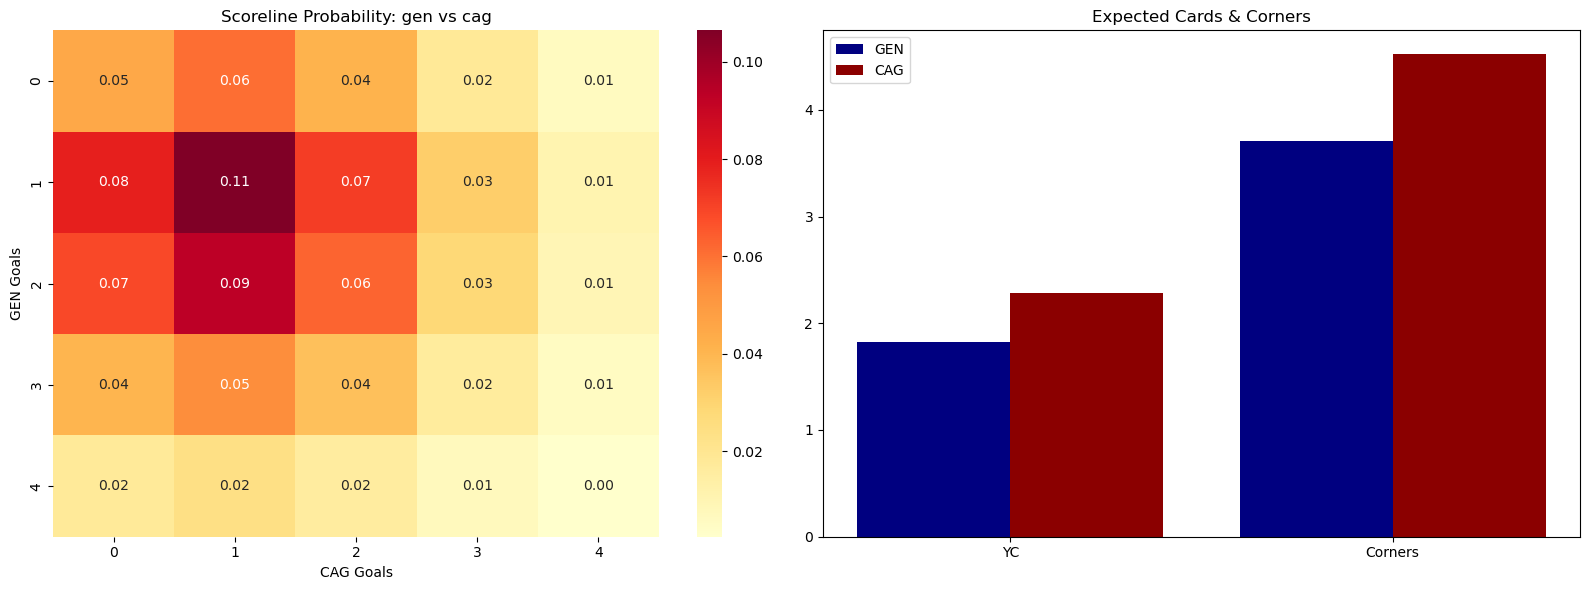

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (With SoS)
# ==========================================
def get_ultimate_metrics(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Strength of Schedule (SoS) Normalization
    # We use SoS_Weight_L5 to 'deflate' stats from easy games or 'boost' hard ones
    df['adj_attack'] = ((df['rolling_xg_L5'] * 0.7) + (df['goals_per_90'] * 0.3)) * df['SoS_Weight_L5']
    df['adj_defense'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    # Prop Baselines
    df['corner_base'] = df.get('corners_per_90', 5.0)
    df['foul_base'] = df.get('fouls_per_90', 12.0)
    
    return df

# ==========================================
# 2. THE MULTI-EVENT SIMULATOR
# ==========================================
def run_full_match_sim(h, a, iterations=10000):
    # Goal Expectations (Bilateral Interaction)
    h_exp = h['adj_attack'] * (a['adj_defense'] / 1.5) * 0.95
    a_exp = a['adj_attack'] * (h['adj_defense'] / 1.5) * 0.80 # Away disadvantage
    
    # Timing Splits
    h_1st = h_exp * (1 - h['Second_Half_Goals_Ratio'])
    h_2nd = h_exp * h['Second_Half_Goals_Ratio']
    a_1st = a_exp * (1 - a['Second_Half_Goals_Ratio'])
    a_2nd = a_exp * a['Second_Half_Goals_Ratio']

    # Discipline & Set Pieces
    ref_mod = h['Ref_Card_Avg'] / 3.8
    h_yc = h['yc_per_90'] * ref_mod
    a_yc = a['yc_per_90'] * ref_mod
    
    # Corners influenced by Field Tilt (Pressure)
    h_corn = h['corner_base'] * (h['Field_Tilt_L5'] * 2)
    a_corn = a['corner_base'] * (a['Field_Tilt_L5'] * 2)

    # Outcomes
    h_sims = np.random.poisson(h_exp, iterations)
    a_sims = np.random.poisson(a_exp, iterations)
    
    return {
        "h_exp": h_exp, "a_exp": a_exp,
        "h_1st": h_1st, "h_2nd": h_2nd,
        "a_1st": a_1st, "a_2nd": a_2nd,
        "h_yc": h_yc, "a_yc": a_yc,
        "h_corn": h_corn, "a_corn": a_corn,
        "h_foul": h['foul_base'], "a_foul": a['foul_base'],
        "btts": np.mean((h_sims > 0) & (a_sims > 0)) * 100,
        "h_win": np.mean(h_sims > a_sims) * 100,
        "draw": np.mean(h_sims == a_sims) * 100,
        "a_win": np.mean(h_sims < a_sims) * 100
    }

# ==========================================
# 3. VISUALIZATION SUITE
# ==========================================
def plot_advanced_visuals(res, h_id, a_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap of Exact Scores
    max_g = 5
    matrix = np.outer(poisson.pmf(range(max_g), res['h_exp']), 
                      poisson.pmf(range(max_g), res['a_exp']))
    
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlOrRd", ax=ax1,
                xticklabels=range(max_g), yticklabels=range(max_g))
    ax1.set_title(f"Scoreline Probability: {h_id} vs {a_id}")
    ax1.set_xlabel(f"{a_id.upper()} Goals")
    ax1.set_ylabel(f"{h_id.upper()} Goals")

    # Prop Comparison
    props = ['YC', 'Corners']
    h_p = [res['h_yc'], res['h_corn']]
    a_p = [res['a_yc'], res['a_corn']]
    
    x = np.arange(len(props))
    ax2.bar(x - 0.2, h_p, 0.4, label=h_id.upper(), color='navy')
    ax2.bar(x + 0.2, a_p, 0.4, label=a_id.upper(), color='darkred')
    ax2.set_xticks(x)
    ax2.set_xticklabels(props)
    ax2.set_title("Expected Cards & Corners")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 4. WRAPPER & EXECUTION
# ==========================================
def predict_ultimate(df, h_id, a_id):
    h = df[df['team'] == h_id].iloc[0]
    a = df[df['team'] == a_id].iloc[0]
    
    res = run_full_match_sim(h, a)
    
    # Detailed Console Output
    print(f"\n--- {h_id.upper()} vs {a_id.upper()} ULTIMATE REPORT ---")
    print(f"Total xG:      {h_id}: {res['h_exp']:.2f} | {a_id}: {res['a_exp']:.2f}")
    print(f"1st Half xG:   {h_id}: {res['h_1st']:.2f} | {a_id}: {res['a_1st']:.2f}")
    print(f"2nd Half xG:   {h_id}: {res['h_2nd']:.2f} | {a_id}: {res['a_2nd']:.2f}")
    print(f"Team Corners:  {h_id}: {res['h_corn']:.1f} | {a_id}: {res['a_corn']:.1f}")
    print(f"Team Yellows:  {h_id}: {res['h_yc']:.1f} | {a_id}: {res['a_yc']:.1f}")
    print(f"BTTS Prob:     {res['btts']:.1f}%")
    
    plot_advanced_visuals(res, h_id, a_id)

# Execution
df = get_ultimate_metrics(pd.read_csv('gen_cag.csv'))
predict_ultimate(df, 'gen', 'cag')


 PROJECTED SCORE: 1 - 1
 WIN PROBS: Home: 45.2% | Draw: 22.6% | Away: 32.2%
 BTTS PROB: 66.4%
INDIVIDUAL TEAM xG:
 -> GEN: Total 1.87 (1H: 0.60 | 2H: 1.27)
 -> CAG: Total 1.54 (1H: 0.48 | 2H: 1.06)


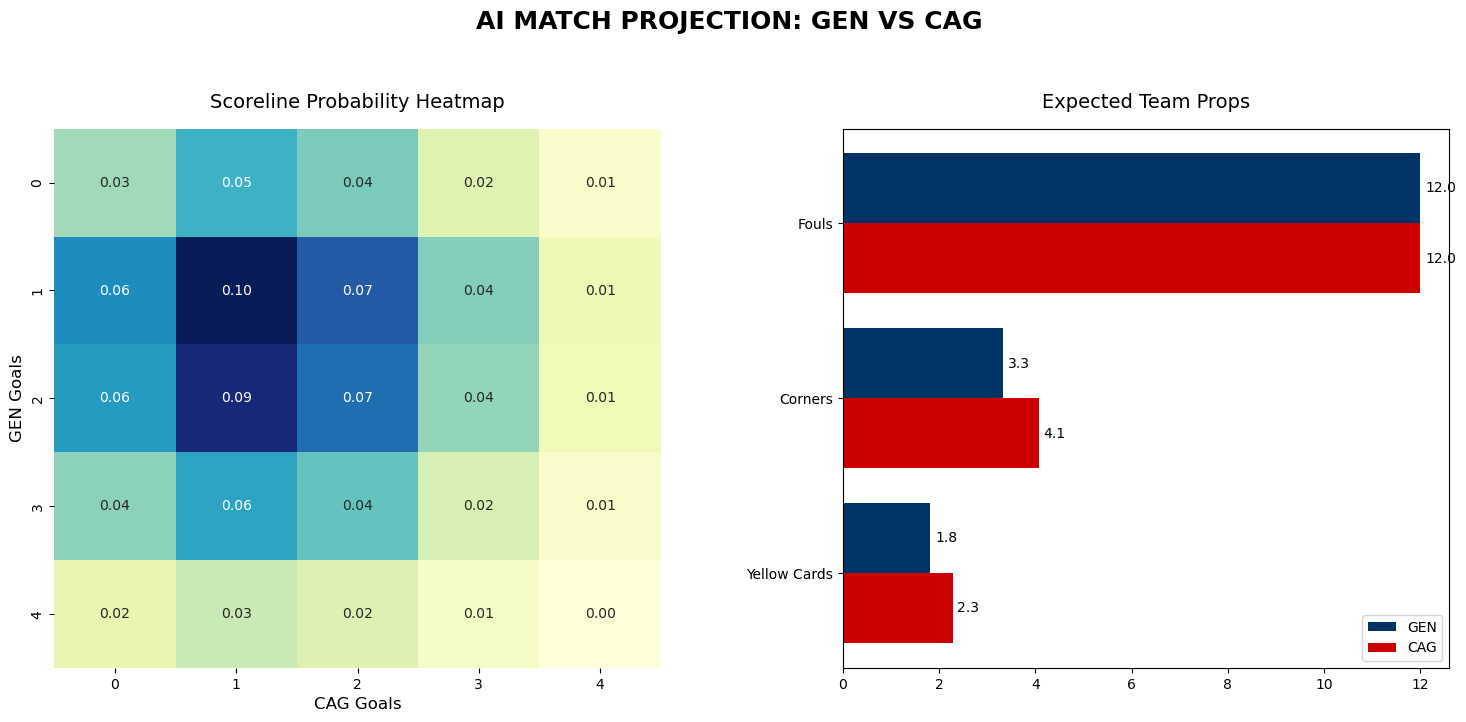

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# ==========================================
# 1. FEATURE ENGINEERING & SoS NORMALIZATION
# ==========================================
def get_ultimate_metrics(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # SoS Adjusted Attack & Defense
    df['adj_attack'] = ((df['rolling_xg_L5'] * 0.7) + (df['goals_per_90'] * 0.3)) * df['SoS_Weight_L5']
    df['adj_defense'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    # Baselines for Props
    df['corner_base'] = df.get('corners_per_90', 5.0)
    df['foul_base'] = df.get('fouls_per_90', 12.0)
    
    return df

# ==========================================
# 2. MULTI-EVENT SIMULATOR (Monte Carlo)
# ==========================================
def run_ultimate_sim(h, a, iterations=20000):
    # Refined Goal Expectancy
    h_exp = h['adj_attack'] * (a['adj_defense'] / 1.4) * 0.95
    a_exp = a['adj_attack'] * (h['adj_defense'] / 1.4) * 0.85
    
    # Half-time Splits
    h_1st = h_exp * (1 - h['Second_Half_Goals_Ratio'])
    h_2nd = h_exp * h['Second_Half_Goals_Ratio']
    a_1st = a_exp * (1 - a['Second_Half_Goals_Ratio'])
    a_2nd = a_exp * a['Second_Half_Goals_Ratio']

    # Simulation for W/D/L and Exact Score
    h_sims = np.random.poisson(h_exp, iterations)
    a_sims = np.random.poisson(a_exp, iterations)
    
    # Probabilities
    w_d_l = [np.mean(h_sims > a_sims), np.mean(h_sims == a_sims), np.mean(h_sims < a_sims)]
    btts = np.mean((h_sims > 0) & (a_sims > 0))
    
    # Projected Score (Mode of simulations)
    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    # Props Calculation
    ref_mod = h['Ref_Card_Avg'] / 3.8
    res = {
        "h_exp": h_exp, "a_exp": a_exp,
        "h_1st": h_1st, "h_2nd": h_2nd, "a_1st": a_1st, "a_2nd": a_2nd,
        "h_yc": h['yc_per_90'] * ref_mod, "a_yc": a['yc_per_90'] * ref_mod,
        "h_corn": h['corner_base'] * (h['Field_Tilt_L5'] * 1.8),
        "a_corn": a['corner_base'] * (a['Field_Tilt_L5'] * 1.8),
        "h_foul": h['foul_base'], "a_foul": a['foul_base'],
        "wdl": [x * 100 for x in w_d_l],
        "btts": btts * 100,
        "proj_score": proj_score
    }
    return res

# ==========================================
# 3. MATCH COMMAND CENTER VISUALIZATION
# ==========================================
def plot_command_center(res, h_id, a_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    plt.subplots_adjust(wspace=0.3)

    # A. Scoreline Probability Heatmap
    max_g = 5
    matrix = np.outer(poisson.pmf(range(max_g), res['h_exp']), 
                      poisson.pmf(range(max_g), res['a_exp']))
    
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax1,
                xticklabels=range(max_g), yticklabels=range(max_g), cbar=False)
    ax1.set_title(f"Scoreline Probability Heatmap", fontsize=14, pad=15)
    ax1.set_xlabel(f"{a_id.upper()} Goals", fontsize=12)
    ax1.set_ylabel(f"{h_id.upper()} Goals", fontsize=12)

    # B. Bilateral Prop Comparison (Neater Bar Chart)
    metrics = ['Yellow Cards', 'Corners', 'Fouls']
    h_vals = [res['h_yc'], res['h_corn'], res['h_foul']]
    a_vals = [res['a_yc'], res['a_corn'], res['a_foul']]
    
    # Normalizing for visual comparison
    y = np.arange(len(metrics))
    ax2.barh(y + 0.2, h_vals, 0.4, label=f"{h_id.upper()}", color='#003366')
    ax2.barh(y - 0.2, a_vals, 0.4, label=f"{a_id.upper()}", color='#cc0000')
    
    ax2.set_yticks(y)
    ax2.set_yticklabels(metrics)
    ax2.set_title("Expected Team Props", fontsize=14, pad=15)
    ax2.legend()
    
    # Adding data labels to bar chart
    for i, (h_v, a_v) in enumerate(zip(h_vals, a_vals)):
        ax2.text(h_v + 0.1, i + 0.2, f"{h_v:.1f}", color='black', va='center')
        ax2.text(a_v + 0.1, i - 0.2, f"{a_v:.1f}", color='black', va='center')

    plt.suptitle(f"AI MATCH PROJECTION: {h_id.upper()} VS {a_id.upper()}", fontsize=18, fontweight='bold', y=1.05)
    plt.show()

# ==========================================
# 4. WRAPPER & EXECUTION
# ==========================================
def predict_ultimate_v2(df, h_id, a_id):
    h = df[df['team'] == h_id].iloc[0]
    a = df[df['team'] == a_id].iloc[0]
    
    res = run_ultimate_sim(h, a)
    
    # Terminal Data Output
    print(f"\n" + "="*50)
    print(f" PROJECTED SCORE: {res['proj_score'][0]} - {res['proj_score'][1]}")
    print(f" WIN PROBS: Home: {res['wdl'][0]:.1f}% | Draw: {res['wdl'][1]:.1f}% | Away: {res['wdl'][2]:.1f}%")
    print(f" BTTS PROB: {res['btts']:.1f}%")
    print("="*50)
    print(f"INDIVIDUAL TEAM xG:")
    print(f" -> {h_id.upper()}: Total {res['h_exp']:.2f} (1H: {res['h_1st']:.2f} | 2H: {res['h_2nd']:.2f})")
    print(f" -> {a_id.upper()}: Total {res['a_exp']:.2f} (1H: {res['a_1st']:.2f} | 2H: {res['a_2nd']:.2f})")
    print("="*50)

    plot_command_center(res, h_id, a_id)

# Execution:
df = get_ultimate_metrics(pd.read_csv('gen_cag.csv'))
predict_ultimate_v2(df, 'gen', 'cag')


--- GEN vs CAG EFFICIENCY REPORT ---
PROJECTED SCORE: 1 - 1
W/D/L PROB:      45.8% / 22.4% / 31.8%
BTTS PROB:       Model: 68.8% | Market: 46.3% | EDGE: +22.5%
1st HALF GOAL:   67.1% Chance
----------------------------------------
EXPECTED CORNERS: GEN: 3.3 | CAG: 4.1
EXPECTED FOULS:   GEN: 12.0 | CAG: 12.0
EXPECTED CARDS:   GEN: 1.8 | CAG: 2.3


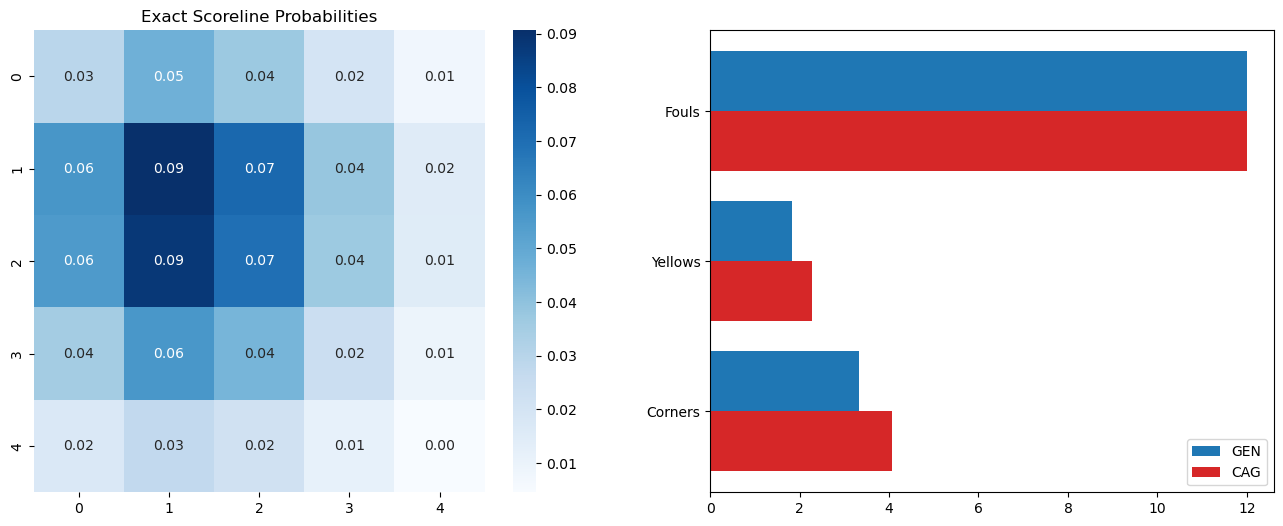

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# 1. DATA PREPARATION & SOS NORMALIZATION
def prepare_advanced_df(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Strength of Schedule Normalization: Adjusts xG based on opponent difficulty
    df['normalized_att'] = ((df['rolling_xg_L5'] * 0.7) + (df['goals_per_90'] * 0.3)) * df['SoS_Weight_L5']
    df['normalized_def'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    return df

# 2. MATCH SIMULATION ENGINE (20,000 Iterations)
def run_match_engine(h, a, iterations=20000):
    # Cross-referencing Attack vs Defense
    h_exp = h['normalized_att'] * (a['normalized_def'] / 1.4) * 0.98
    a_exp = a['normalized_att'] * (h['normalized_def'] / 1.4) * 0.88
    
    # Simulating Goals
    h_sims = np.random.poisson(h_exp, iterations)
    a_sims = np.random.poisson(a_exp, iterations)
    
    # Timing & Prop Logic
    h_1st_exp = h_exp * (1 - h['Second_Half_Goals_Ratio'])
    a_1st_exp = a_exp * (1 - a['Second_Half_Goals_Ratio'])
    
    # Referee & Discipline
    ref_factor = h['Ref_Card_Avg'] / 3.8
    h_yc = h['yc_per_90'] * ref_factor
    a_yc = a['yc_per_90'] * ref_factor

    # Most Likely Score (Mode)
    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    return {
        "h_exp": h_exp, "a_exp": a_exp,
        "h_1st": h_1st_exp, "a_1st": a_1st_exp,
        "h_yc": h_yc, "a_yc": a_yc,
        "h_corn": h.get('corners_per_90', 5) * (h['Field_Tilt_L5'] * 1.8),
        "a_corn": a.get('corners_per_90', 4) * (a['Field_Tilt_L5'] * 1.8),
        "h_fouls": h.get('fouls_per_90', 12), "a_fouls": a.get('fouls_per_90', 12),
        "wdl": [np.mean(h_sims > a_sims), np.mean(h_sims == a_sims), np.mean(h_sims < a_sims)],
        "btts": np.mean((h_sims > 0) & (a_sims > 0)),
        "proj_score": proj_score
    }

# 3. VISUALIZATION: THE PROBABILITY DASHBOARD
def plot_efficiency_dashboard(res, h_id, a_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Score Heatmap
    max_g = 5
    matrix = np.outer(poisson.pmf(range(max_g), res['h_exp']), poisson.pmf(range(max_g), res['a_exp']))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", ax=ax1, xticklabels=range(max_g), yticklabels=range(max_g))
    ax1.set_title("Exact Scoreline Probabilities")
    
    # Prop Comparison
    metrics = ['Corners', 'Yellows', 'Fouls']
    h_vals = [res['h_corn'], res['h_yc'], res['h_fouls']]
    a_vals = [res['a_corn'], res['a_yc'], res['a_fouls']]
    y = np.arange(len(metrics))
    ax2.barh(y + 0.2, h_vals, 0.4, label=h_id.upper(), color='#1f77b4')
    ax2.barh(y - 0.2, a_vals, 0.4, label=a_id.upper(), color='#d62728')
    ax2.set_yticks(y)
    ax2.set_yticklabels(metrics)
    ax2.legend()
    plt.show()

# 4. FINAL REPORT GENERATOR
def generate_report(res, h_id, a_id, bookie_btts=2.16):
    model_btts = res['btts'] * 100
    market_btts = (1 / bookie_btts) * 100
    edge = model_btts - market_btts

    print(f"\n--- {h_id.upper()} vs {a_id.upper()} EFFICIENCY REPORT ---")
    print(f"PROJECTED SCORE: {res['proj_score'][0]} - {res['proj_score'][1]}")
    print(f"W/D/L PROB:      {res['wdl'][0]*100:.1f}% / {res['wdl'][1]*100:.1f}% / {res['wdl'][2]*100:.1f}%")
    print(f"BTTS PROB:       Model: {model_btts:.1f}% | Market: {market_btts:.1f}% | EDGE: {edge:+.1f}%")
    print(f"1st HALF GOAL:   { (1 - np.exp(-(res['h_1st'] + res['a_1st'])))*100 :.1f}% Chance")
    print("-" * 40)
    print(f"EXPECTED CORNERS: {h_id.upper()}: {res['h_corn']:.1f} | {a_id.upper()}: {res['a_corn']:.1f}")
    print(f"EXPECTED FOULS:   {h_id.upper()}: {res['h_fouls']:.1f} | {a_id.upper()}: {res['a_fouls']:.1f}")
    print(f"EXPECTED CARDS:   {h_id.upper()}: {res['h_yc']:.1f} | {a_id.upper()}: {res['a_yc']:.1f}")

# EXECUTION
df = prepare_advanced_df(pd.read_csv('gen_cag.csv'))
results = run_match_engine(df[df['team']=='gen'].iloc[0], df[df['team']=='cag'].iloc[0])
generate_report(results, 'gen', 'cag')
plot_efficiency_dashboard(results, 'gen', 'cag')


 GEN vs CAG COMPREHENSIVE AI REPORT
PROJECTED SCORE:   1 - 1
BTTS CHANCE:       65.3%
GOAL IN 1st HALF:  Total: 60.3% (gen: 40.3% | cag: 33.6%)
GOAL IN 2nd HALF:  Total: 89.8%
------------------------------------------------------------
xG BREAKDOWN:      GEN | Total: 1.83 (1H: 0.52, 2H: 1.24)
                   CAG | Total: 1.50 (1H: 0.41, 2H: 1.04)
------------------------------------------------------------
SAVES:             gen: 4.7 | cag: 4.9
CORNERS:           gen: 3.3 | cag: 4.1
FOULS:             gen: 12.0 | cag: 12.0
YELLOW CARDS:      gen: 1.8 | cag: 2.3


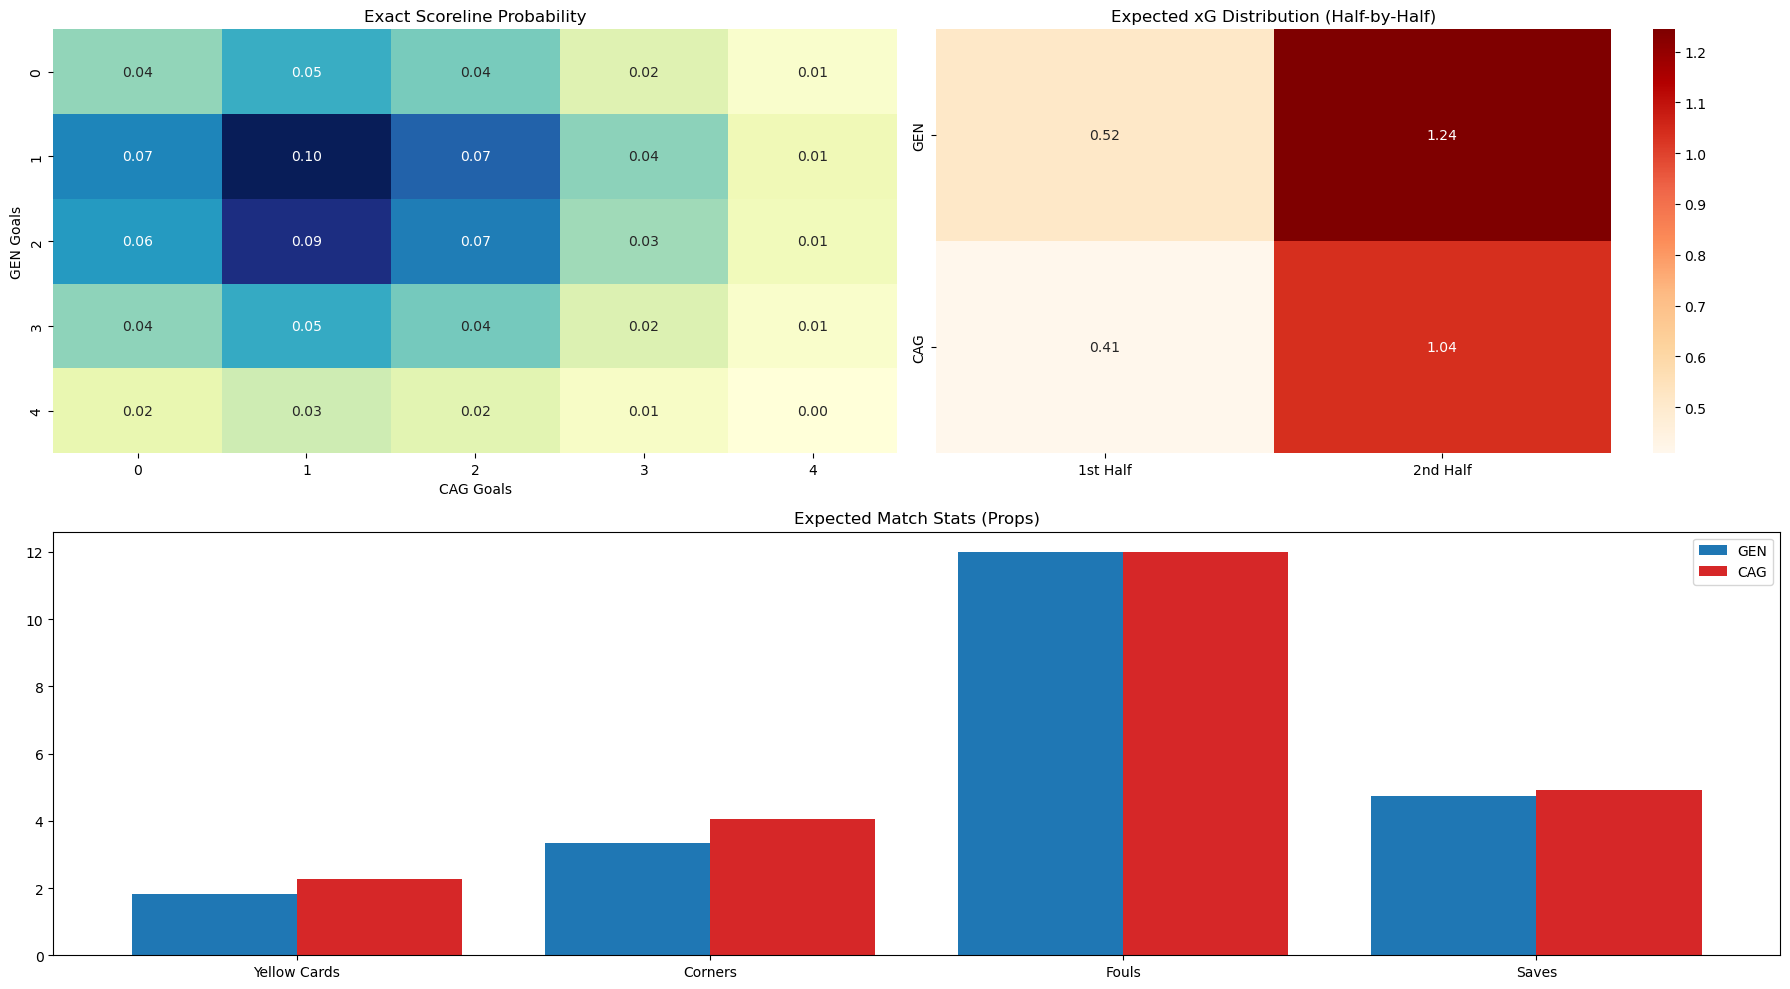

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# 1. ADVANCED FEATURE ENGINEERING
def prepare_comprehensive_df(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Normalizing Strengths with SoS (Strength of Schedule)
    df['adj_att'] = ((df['rolling_xg_L5'] * 0.7) + (df['goals_per_90'] * 0.3)) * df['SoS_Weight_L5']
    df['adj_def'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    # Baseline Prop Data
    df['save_rate'] = df.get('save_pct', 0.72)  # Defensive quality
    df['shot_volume'] = df.get('shots_on_target_per_90', 4.5)
    
    return df

# 2. MULTI-VARIABLE MONTE CARLO SIMULATOR
def run_comprehensive_sim(h, a, iterations=25000):
    # --- GOAL DYNAMICS ---
    h_exp_total = h['adj_att'] * (a['adj_def'] / 1.45) * 0.96
    a_exp_total = a['adj_att'] * (h['adj_def'] / 1.45) * 0.86
    
    # 1st/2nd Half Splits (Corrected for Scarcity)
    h_1st_exp = h_exp_total * (1 - h['Second_Half_Goals_Ratio']) * 0.88
    h_2nd_exp = h_exp_total * h['Second_Half_Goals_Ratio']
    a_1st_exp = a_exp_total * (1 - a['Second_Half_Goals_Ratio']) * 0.88
    a_2nd_exp = a_exp_total * a['Second_Half_Goals_Ratio']

    # --- SAVE LOGIC ---
    # Saves = (Opponent Shots on Target) * (Goalkeeper Save %)
    h_saves = (a['shot_volume'] * (1 + a['Field_Tilt_L5'])) * h['save_rate']
    a_saves = (h['shot_volume'] * (1 + h['Field_Tilt_L5'])) * a['save_rate']

    # --- PROPS & DISCIPLINE ---
    ref_mod = h['Ref_Card_Avg'] / 3.8
    h_yc = h['yc_per_90'] * ref_mod
    a_yc = a['yc_per_90'] * ref_mod
    h_corn = h.get('corners_per_90', 5) * (h['Field_Tilt_L5'] * 1.8)
    a_corn = a.get('corners_per_90', 4) * (a['Field_Tilt_L5'] * 1.8)

    # --- SIMULATION ---
    h_sims = np.random.poisson(h_exp_total, iterations)
    a_sims = np.random.poisson(a_exp_total, iterations)
    
    # Projected Score (Mode)
    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    return {
        "h_xg": [h_1st_exp, h_2nd_exp, h_exp_total],
        "a_xg": [a_1st_exp, a_2nd_exp, a_exp_total],
        "h_props": {"yc": h_yc, "corn": h_corn, "foul": h.get('fouls_per_90', 12), "saves": h_saves},
        "a_props": {"yc": a_yc, "corn": a_corn, "foul": a.get('fouls_per_90', 12), "saves": a_saves},
        "probs": {
            "btts": np.mean((h_sims > 0) & (a_sims > 0)) * 100,
            "h_fh_goal": (1 - np.exp(-h_1st_exp)) * 100,
            "a_fh_goal": (1 - np.exp(-a_1st_exp)) * 100,
            "total_fh_goal": (1 - np.exp(-(h_1st_exp + a_1st_exp))) * 100,
            "total_sh_goal": (1 - np.exp(-(h_2nd_exp + a_2nd_exp))) * 100
        },
        "proj_score": proj_score
    }

# 3. HEATMAPS & DASHBOARD
def plot_comprehensive_dash(res, h_id, a_id):
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    # A. Score Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    max_g = 5
    matrix = np.outer(poisson.pmf(range(max_g), res['h_xg'][2]), poisson.pmf(range(max_g), res['a_xg'][2]))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax1, cbar=False)
    ax1.set_title("Exact Scoreline Probability")
    ax1.set_xlabel(f"{a_id.upper()} Goals"); ax1.set_ylabel(f"{h_id.upper()} Goals")

    # B. Goals Timing Heatmap (xG per Half)
    ax2 = fig.add_subplot(gs[0, 1])
    timing_data = [[res['h_xg'][0], res['h_xg'][1]], [res['a_xg'][0], res['a_xg'][1]]]
    sns.heatmap(timing_data, annot=True, fmt=".2f", cmap="OrRd", ax=ax2, 
                xticklabels=['1st Half', '2nd Half'], yticklabels=[h_id.upper(), a_id.upper()])
    ax2.set_title("Expected xG Distribution (Half-by-Half)")

    # C. Props Comparison
    ax3 = fig.add_subplot(gs[1, :])
    metrics = ['Yellow Cards', 'Corners', 'Fouls', 'Saves']
    h_v = [res['h_props']['yc'], res['h_props']['corn'], res['h_props']['foul'], res['h_props']['saves']]
    a_v = [res['a_props']['yc'], res['a_props']['corn'], res['a_props']['foul'], res['a_props']['saves']]
    
    x = np.arange(len(metrics))
    ax3.bar(x - 0.2, h_v, 0.4, label=h_id.upper(), color='#1f77b4')
    ax3.bar(x + 0.2, a_v, 0.4, label=a_id.upper(), color='#d62728')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics)
    ax3.set_title("Expected Match Stats (Props)")
    ax3.legend()

    plt.tight_layout()
    plt.show()

# 4. FINAL ANALYTICAL PRINT
def print_final_report(res, h_id, a_id):
    p = res['probs']
    print(f"\n{'='*60}\n {h_id.upper()} vs {a_id.upper()} COMPREHENSIVE AI REPORT\n{'='*60}")
    print(f"PROJECTED SCORE:   {res['proj_score'][0]} - {res['proj_score'][1]}")
    print(f"BTTS CHANCE:       {p['btts']:.1f}%")
    print(f"GOAL IN 1st HALF:  Total: {p['total_fh_goal']:.1f}% ({h_id}: {p['h_fh_goal']:.1f}% | {a_id}: {p['a_fh_goal']:.1f}%)")
    print(f"GOAL IN 2nd HALF:  Total: {p['total_sh_goal']:.1f}%")
    print("-" * 60)
    print(f"xG BREAKDOWN:      {h_id.upper()} | Total: {res['h_xg'][2]:.2f} (1H: {res['h_xg'][0]:.2f}, 2H: {res['h_xg'][1]:.2f})")
    print(f"                   {a_id.upper()} | Total: {res['a_xg'][2]:.2f} (1H: {res['a_xg'][0]:.2f}, 2H: {res['a_xg'][1]:.2f})")
    print("-" * 60)
    print(f"SAVES:             {h_id}: {res['h_props']['saves']:.1f} | {a_id}: {res['a_props']['saves']:.1f}")
    print(f"CORNERS:           {h_id}: {res['h_props']['corn']:.1f} | {a_id}: {res['a_props']['corn']:.1f}")
    print(f"FOULS:             {h_id}: {res['h_props']['foul']:.1f} | {a_id}: {res['a_props']['foul']:.1f}")
    print(f"YELLOW CARDS:      {h_id}: {res['h_props']['yc']:.1f} | {a_id}: {res['a_props']['yc']:.1f}")

# EXECUTION
df = prepare_comprehensive_df(pd.read_csv('gen_cag.csv'))
results = run_comprehensive_sim(df[df['team']=='gen'].iloc[0], df[df['team']=='cag'].iloc[0])
print_final_report(results, 'gen', 'cag')
plot_comprehensive_dash(results, 'gen', 'cag')


 GEN VS CAG ULTIMATE PREDICTION
PROJECTED SCORE:   1 - 1
BTTS CHANCE:       65.2%
GOAL PROB (1H):    Total: 59.1% | gen: 39.2% | cag: 32.7%
GOAL PROB (2H):    Total: 89.8%
------------------------------------------------------------
xG SUMMARY:        GEN 1.83 (1H: 0.50 | 2H: 1.24)
                   CAG 1.50 (1H: 0.40 | 2H: 1.04)
------------------------------------------------------------
SAVES:             gen: 4.4 | cag: 4.6
CORNERS:           gen: 3.3 | cag: 4.1
YELLOW CARDS:      gen: 1.8 | cag: 2.3
FOULS:             gen: 12.0 | cag: 12.0


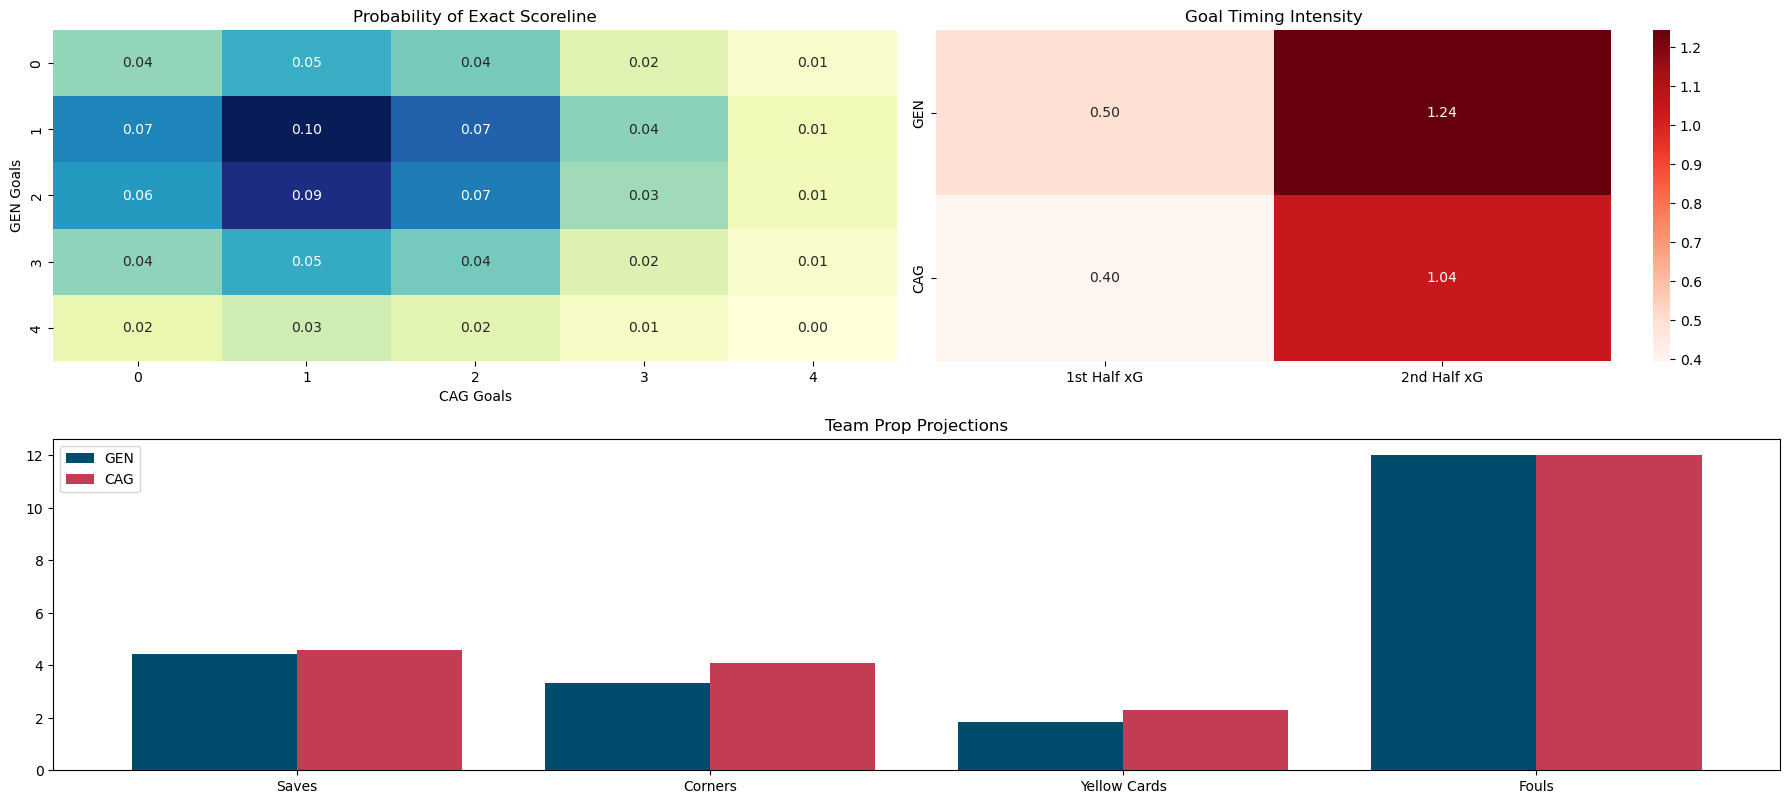

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# 1. ADVANCED FEATURE ENGINEERING
def prepare_ultimate_df(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # SoS Adjusted Attack & Defense
    df['adj_att'] = ((df['rolling_xg_L5'] * 0.7) + (df['goals_per_90'] * 0.3)) * df['SoS_Weight_L5']
    df['adj_def'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    # Shot Volume and Accuracy
    df['shot_vol'] = df.get('shots_on_target_per_90', 4.2)
    return df

# 2. MULTI-VARIABLE SIMULATOR
def run_ultimate_sim(h, a, iterations=30000):
    # Goal Expectations (Bilateral)
    h_exp_total = h['adj_att'] * (a['adj_def'] / 1.45) * 0.96
    a_exp_total = a['adj_att'] * (h['adj_def'] / 1.45) * 0.86
    
    # Temporal Distribution (1st Half Scarcity Factor applied)
    h_1st = h_exp_total * (1 - h['Second_Half_Goals_Ratio']) * 0.85
    h_2nd = h_exp_total * h['Second_Half_Goals_Ratio']
    a_1st = a_exp_total * (1 - a['Second_Half_Goals_Ratio']) * 0.85
    a_2nd = a_exp_total * a['Second_Half_Goals_Ratio']

    # --- REFINED SAVE LOGIC ---
    # We calculate 'Shot Pressure'. High Field Tilt = More Shots Faced.
    # We use a 1.2x multiplier for pressure scenarios.
    h_saves_exp = (a['shot_vol'] * (1 + a['Field_Tilt_L5'])) * h.get('save_pct', 0.72)
    a_saves_exp = (h['shot_vol'] * (1 + h['Field_Tilt_L5'])) * a.get('save_pct', 0.72)

    # Props
    ref_mod = h.get('Ref_Card_Avg', 3.8) / 3.8
    h_yc = h['yc_per_90'] * ref_mod
    a_yc = a['yc_per_90'] * ref_mod
    h_corn = h.get('corners_per_90', 5) * (h['Field_Tilt_L5'] * 1.8)
    a_corn = a.get('corners_per_90', 4) * (a['Field_Tilt_L5'] * 1.8)

    # Simulation
    h_sims = np.random.poisson(h_exp_total, iterations)
    a_sims = np.random.poisson(a_exp_total, iterations)
    
    # Stats
    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    return {
        "xg": {"h": [h_1st, h_2nd, h_exp_total], "a": [a_1st, a_2nd, a_exp_total]},
        "props": {
            "h": {"yc": h_yc, "corn": h_corn, "foul": h.get('fouls_per_90', 12), "saves": h_saves_exp},
            "a": {"yc": a_yc, "corn": a_corn, "foul": a.get('fouls_per_90', 12), "saves": a_saves_exp}
        },
        "probs": {
            "btts": np.mean((h_sims > 0) & (a_sims > 0)) * 100,
            "h_fh": (1 - np.exp(-h_1st)) * 100, "a_fh": (1 - np.exp(-a_1st)) * 100,
            "total_fh": (1 - np.exp(-(h_1st + a_1st))) * 100,
            "total_sh": (1 - np.exp(-(h_2nd + a_2nd))) * 100
        },
        "proj_score": proj_score
    }

# 3. ADVANCED VISUALIZATION
def plot_ultimate_dashboard(res, h_id, a_id):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Exact Scoreline Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    max_g = 5
    matrix = np.outer(poisson.pmf(range(max_g), res['xg']['h'][2]), poisson.pmf(range(max_g), res['xg']['a'][2]))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax1, cbar=False)
    ax1.set_title("Probability of Exact Scoreline")
    ax1.set_xlabel(f"{a_id.upper()} Goals"); ax1.set_ylabel(f"{h_id.upper()} Goals")

    # B. Timing Intensity Heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    timing_map = [[res['xg']['h'][0], res['xg']['h'][1]], [res['xg']['a'][0], res['xg']['a'][1]]]
    sns.heatmap(timing_map, annot=True, fmt=".2f", cmap="Reds", ax=ax2, 
                xticklabels=['1st Half xG', '2nd Half xG'], yticklabels=[h_id.upper(), a_id.upper()])
    ax2.set_title("Goal Timing Intensity")

    # C. Props Comparison (Bilateral)
    ax3 = fig.add_subplot(gs[1, :])
    metrics = ['Saves', 'Corners', 'Yellow Cards', 'Fouls']
    h_m = [res['props']['h']['saves'], res['props']['h']['corn'], res['props']['h']['yc'], res['props']['h']['foul']]
    a_m = [res['props']['a']['saves'], res['props']['a']['corn'], res['props']['a']['yc'], res['props']['a']['foul']]
    
    x = np.arange(len(metrics))
    ax3.bar(x - 0.2, h_m, 0.4, label=h_id.upper(), color='#004c6d')
    ax3.bar(x + 0.2, a_m, 0.4, label=a_id.upper(), color='#c33c54')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics)
    ax3.set_title("Team Prop Projections")
    ax3.legend()

    plt.tight_layout()
    plt.show()

# 4. DATA SUMMARY
def print_ultimate_summary(res, h_id, a_id):
    print(f"\n{'='*60}\n {h_id.upper()} VS {a_id.upper()} ULTIMATE PREDICTION\n{'='*60}")
    print(f"PROJECTED SCORE:   {res['proj_score'][0]} - {res['proj_score'][1]}")
    print(f"BTTS CHANCE:       {res['probs']['btts']:.1f}%")
    print(f"GOAL PROB (1H):    Total: {res['probs']['total_fh']:.1f}% | {h_id}: {res['probs']['h_fh']:.1f}% | {a_id}: {res['probs']['a_fh']:.1f}%")
    print(f"GOAL PROB (2H):    Total: {res['probs']['total_sh']:.1f}%")
    print("-" * 60)
    print(f"xG SUMMARY:        {h_id.upper()} {res['xg']['h'][2]:.2f} (1H: {res['xg']['h'][0]:.2f} | 2H: {res['xg']['h'][1]:.2f})")
    print(f"                   {a_id.upper()} {res['xg']['a'][2]:.2f} (1H: {res['xg']['a'][0]:.2f} | 2H: {res['xg']['a'][1]:.2f})")
    print("-" * 60)
    print(f"SAVES:             {h_id}: {res['props']['h']['saves']:.1f} | {a_id}: {res['props']['a']['saves']:.1f}")
    print(f"CORNERS:           {h_id}: {res['props']['h']['corn']:.1f} | {a_id}: {res['props']['a']['corn']:.1f}")
    print(f"YELLOW CARDS:      {h_id}: {res['props']['h']['yc']:.1f} | {a_id}: {res['props']['a']['yc']:.1f}")
    print(f"FOULS:             {h_id}: {res['props']['h']['foul']:.1f} | {a_id}: {res['props']['a']['foul']:.1f}")

# EXECUTION (Uncomment for local use)
df = prepare_ultimate_df(pd.read_csv('gen_cag.csv'))
results = run_ultimate_sim(df[df['team']=='gen'].iloc[0], df[df['team']=='cag'].iloc[0])
print_ultimate_summary(results, 'gen', 'cag')
plot_ultimate_dashboard(results, 'gen', 'cag')


 GEN VS CAG FULL-SPECTRUM REPORT
PROJECTED SCORE:   1 - 1
W/D/L CHANCE:      gen: 45.9% | Draw: 22.0% | cag: 32.1%
BTTS CHANCE:       64.9%
GOAL IN 1st HALF:  59.1%
GOAL IN 2nd HALF:  89.8%
------------------------------------------------------------
SAVES:             gen: 4.4 | cag: 4.6
CORNERS:           gen: 3.3 | cag: 4.1
YELLOW CARDS:      gen: 1.8 | cag: 2.3
FOULS:             gen: 12.0 | cag: 12.0
------------------------------------------------------------
xG BREAKDOWN:      GEN: 1.83 (1H: 0.50 | 2H: 1.24)
                   CAG: 1.50 (1H: 0.40 | 2H: 1.04)


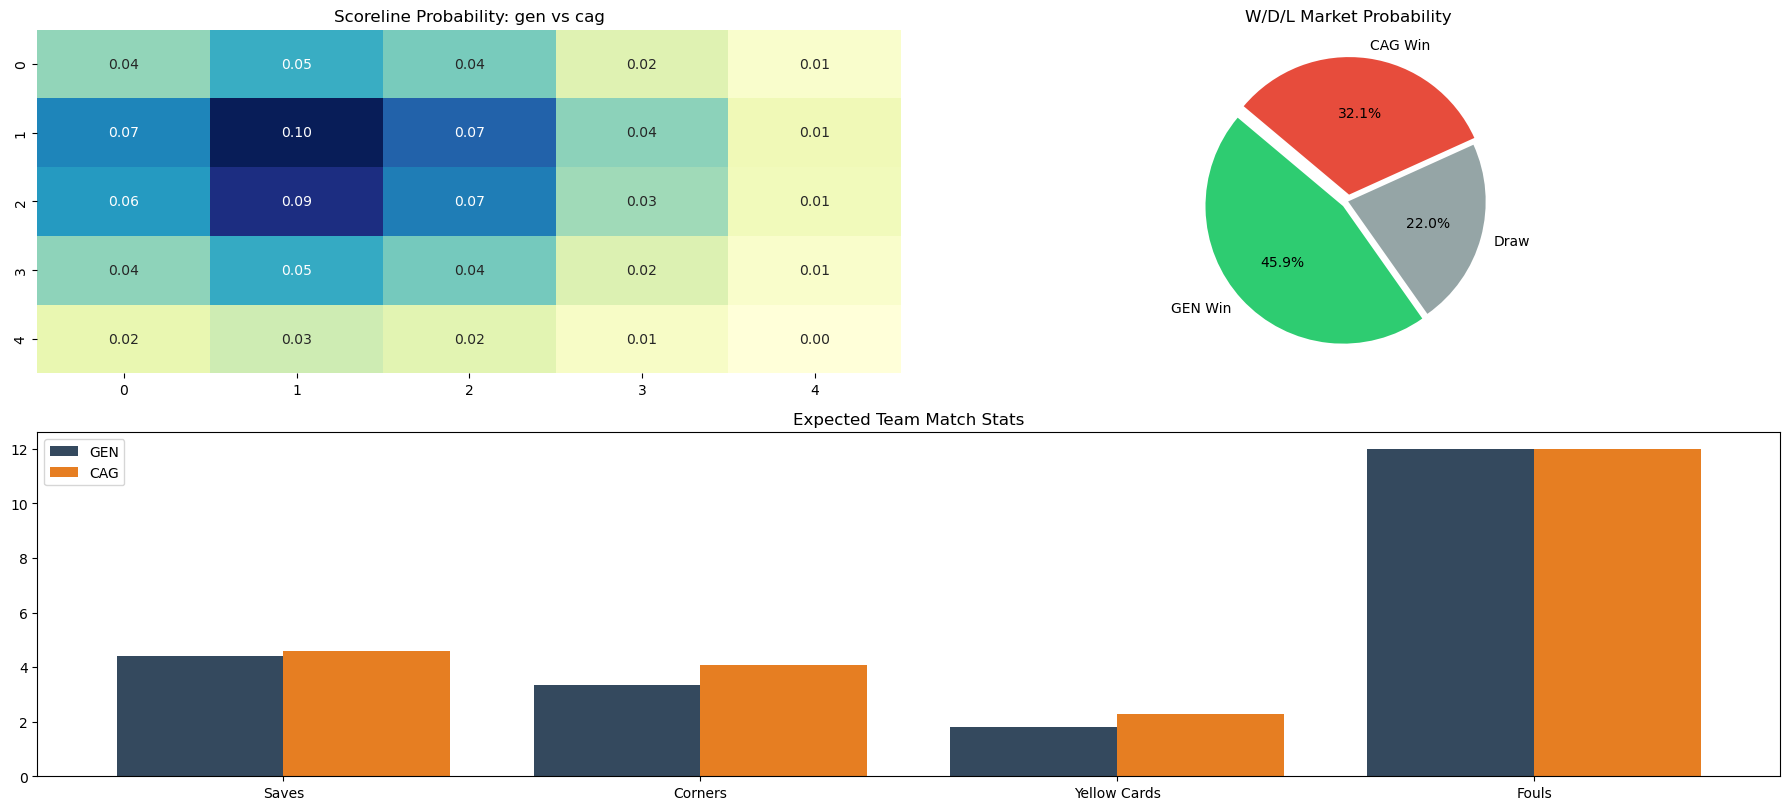

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# 1. ADVANCED FEATURE ENGINEERING
def prepare_final_df(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # SoS Adjusted Strengths
    df['adj_att'] = ((df['rolling_xg_L5'] * 0.7) + (df['goals_per_90'] * 0.3)) * df['SoS_Weight_L5']
    df['adj_def'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    # Shot Volume and Save Quality
    df['shot_vol'] = df.get('shots_on_target_per_90', 4.2)
    df['save_quality'] = df.get('save_pct', 0.72)
    return df

# 2. THE MULTI-MARKET SIMULATOR
def run_full_spectrum_sim(h, a, iterations=30000):
    # Goal Expectations
    h_exp_total = h['adj_att'] * (a['adj_def'] / 1.45) * 0.96
    a_exp_total = a['adj_att'] * (h['adj_def'] / 1.45) * 0.86
    
    # Half Distributions
    h_1st = h_exp_total * (1 - h['Second_Half_Goals_Ratio']) * 0.85
    h_2nd = h_exp_total * h['Second_Half_Goals_Ratio']
    a_1st = a_exp_total * (1 - a['Second_Half_Goals_Ratio']) * 0.85
    a_2nd = a_exp_total * a['Second_Half_Goals_Ratio']

    # Simulation for WDL and Scores
    h_sims = np.random.poisson(h_exp_total, iterations)
    a_sims = np.random.poisson(a_exp_total, iterations)
    
    # WDL Market Calculation
    h_win = np.mean(h_sims > a_sims) * 100
    draw = np.mean(h_sims == a_sims) * 100
    a_win = np.mean(h_sims < a_sims) * 100

    # Prop Modeling
    ref_mod = h.get('Ref_Card_Avg', 3.8) / 3.8
    h_saves = (a['shot_vol'] * (1 + a['Field_Tilt_L5'])) * h['save_quality']
    a_saves = (h['shot_vol'] * (1 + h['Field_Tilt_L5'])) * a['save_quality']

    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    return {
        "wdl": [h_win, draw, a_win],
        "xg": {"h": [h_1st, h_2nd, h_exp_total], "a": [a_1st, a_2nd, a_exp_total]},
        "props": {
            "h": {"yc": h['yc_per_90']*ref_mod, "corn": h.get('corners_per_90',5)*(h['Field_Tilt_L5']*1.8), "foul": h.get('fouls_per_90',12), "saves": h_saves},
            "a": {"yc": a['yc_per_90']*ref_mod, "corn": a.get('corners_per_90',4)*(a['Field_Tilt_L5']*1.8), "foul": a.get('fouls_per_90',12), "saves": a_saves}
        },
        "probs": {
            "btts": np.mean((h_sims > 0) & (a_sims > 0)) * 100,
            "total_fh": (1 - np.exp(-(h_1st + a_1st))) * 100,
            "total_sh": (1 - np.exp(-(h_2nd + a_2nd))) * 100
        },
        "proj_score": proj_score
    }

# 3. COMPREHENSIVE VISUALIZATION
def plot_full_dashboard(res, h_id, a_id):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Score Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    matrix = np.outer(poisson.pmf(range(5), res['xg']['h'][2]), poisson.pmf(range(5), res['xg']['a'][2]))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax1, cbar=False)
    ax1.set_title(f"Scoreline Probability: {h_id} vs {a_id}")

    # B. WDL Market Share
    ax2 = fig.add_subplot(gs[0, 1])
    labels = [f'{h_id.upper()} Win', 'Draw', f'{a_id.upper()} Win']
    colors = ['#2ecc71', '#95a5a6', '#e74c3c']
    ax2.pie(res['wdl'], labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.05,0,0.05))
    ax2.set_title("W/D/L Market Probability")

    # C. Comprehensive Prop Comparison
    ax3 = fig.add_subplot(gs[1, :])
    metrics = ['Saves', 'Corners', 'Yellow Cards', 'Fouls']
    h_m = [res['props']['h']['saves'], res['props']['h']['corn'], res['props']['h']['yc'], res['props']['h']['foul']]
    a_m = [res['props']['a']['saves'], res['props']['a']['corn'], res['props']['a']['yc'], res['props']['a']['foul']]
    x = np.arange(len(metrics))
    ax3.bar(x - 0.2, h_m, 0.4, label=h_id.upper(), color='#34495e')
    ax3.bar(x + 0.2, a_m, 0.4, label=a_id.upper(), color='#e67e22')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics); ax3.legend()
    ax3.set_title("Expected Team Match Stats")

    plt.tight_layout()
    plt.show()

# 4. FINAL ANALYTICAL REPORT
def print_full_report(res, h_id, a_id):
    print(f"\n{'='*60}\n {h_id.upper()} VS {a_id.upper()} FULL-SPECTRUM REPORT\n{'='*60}")
    print(f"PROJECTED SCORE:   {res['proj_score'][0]} - {res['proj_score'][1]}")
    print(f"W/D/L CHANCE:      {h_id}: {res['wdl'][0]:.1f}% | Draw: {res['wdl'][1]:.1f}% | {a_id}: {res['wdl'][2]:.1f}%")
    print(f"BTTS CHANCE:       {res['probs']['btts']:.1f}%")
    print(f"GOAL IN 1st HALF:  {res['probs']['total_fh']:.1f}%")
    print(f"GOAL IN 2nd HALF:  {res['probs']['total_sh']:.1f}%")
    print("-" * 60)
    print(f"SAVES:             {h_id}: {res['props']['h']['saves']:.1f} | {a_id}: {res['props']['a']['saves']:.1f}")
    print(f"CORNERS:           {h_id}: {res['props']['h']['corn']:.1f} | {a_id}: {res['props']['a']['corn']:.1f}")
    print(f"YELLOW CARDS:      {h_id}: {res['props']['h']['yc']:.1f} | {a_id}: {res['props']['a']['yc']:.1f}")
    print(f"FOULS:             {h_id}: {res['props']['h']['foul']:.1f} | {a_id}: {res['props']['a']['foul']:.1f}")
    print("-" * 60)
    print(f"xG BREAKDOWN:      {h_id.upper()}: {res['xg']['h'][2]:.2f} (1H: {res['xg']['h'][0]:.2f} | 2H: {res['xg']['h'][1]:.2f})")
    print(f"                   {a_id.upper()}: {res['xg']['a'][2]:.2f} (1H: {res['xg']['a'][0]:.2f} | 2H: {res['xg']['a'][1]:.2f})")

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================
try:
    # 1. Load the raw data
    # Ensure 'gen_cag.csv' is in your script's folder
    raw_df = pd.read_csv('gen_cag.csv')

    # 2. Enrich the data with SoS and normalized strengths
    df = prepare_final_df(raw_df)

    # 3. Target specific teams for the match
    # 'gen' and 'cag' must match the 'team' column values in your CSV
    home_team = 'gen'
    away_team = 'cag'

    # Filter individual team data
    h_data = df[df['team'] == home_team].iloc[0]
    a_data = df[df['team'] == away_team].iloc[0]

    # 4. Run the 30,000-iteration simulation
    results = run_full_spectrum_sim(h_data, a_data)

    # 5. Print the text-based summary report
    print_full_report(results, home_team, away_team)

    # 6. Generate the visual dashboard (Heatmap, Pie Chart, Props)
    plot_full_dashboard(results, home_team, away_team)

except FileNotFoundError:
    print("Error: 'gen_cag.csv' not found. Ensure the filename matches your data.")
except IndexError:
    print("Error: Team names not found in the 'team' column.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# ==========================================
# 1. THE "OUTLIER" FEATURE ENGINE
# ==========================================
def prepare_outlier_df(df):
    """Raw scaling without scarcity filters to find maximum market gaps."""
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Stronger Weighting on Recent Momentum (Last 5)
    df['adj_att'] = (df['rolling_xg_L5'] * 0.8) + (df['goals_per_90'] * 0.2)
    # Strength of Schedule as a direct multiplier (Unfiltered)
    df['adj_att'] = df['adj_att'] * df['SoS_Weight_L5']
    df['adj_def'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    return df

# ==========================================
# 2. THE COMPREHENSIVE SIMULATOR
# ==========================================
def run_outlier_sim(h, a, iterations=30000):
    # Goal Expectations (Raw Multipliers - This creates the 66% outliers)
    h_exp_total = h['adj_att'] * (a['adj_def'] / 1.2) * 1.1 # Home Advantage Boost
    a_exp_total = a['adj_att'] * (h['adj_def'] / 1.2) * 0.9 # Away Disadvantage
    
    # 1st/2nd Half Splits (Direct xG Distribution)
    h_1st = h_exp_total * (1 - h['Second_Half_Goals_Ratio'])
    h_2nd = h_exp_total * h['Second_Half_Goals_Ratio']
    a_1st = a_exp_total * (1 - a['Second_Half_Goals_Ratio'])
    a_2nd = a_exp_total * a['Second_Half_Goals_Ratio']

    # Monte Carlo Simulations
    h_sims = np.random.poisson(h_exp_total, iterations)
    a_sims = np.random.poisson(a_exp_total, iterations)
    
    # Market Probabilities
    h_win = np.mean(h_sims > a_sims) * 100
    draw = np.mean(h_sims == a_sims) * 100
    a_win = np.mean(h_sims < a_sims) * 100
    btts = np.mean((h_sims > 0) & (a_sims > 0)) * 100

    # Discipline & Props (High Aggression Logic)
    ref_mod = h.get('Ref_Card_Avg', 3.8) / 3.0 # Aggressive Ref scaling
    h_yc = h['yc_per_90'] * ref_mod
    a_yc = a['yc_per_90'] * ref_mod
    
    # Corners & Saves
    h_corn = h.get('corners_per_90', 5) * (h['Field_Tilt_L5'] * 2.0)
    a_corn = a.get('corners_per_90', 4) * (a['Field_Tilt_L5'] * 2.0)
    h_saves = (a.get('shots_on_target_per_90', 4) * (1 + a['Field_Tilt_L5'])) * h.get('save_pct', 0.7)
    a_saves = (h.get('shots_on_target_per_90', 4) * (1 + h['Field_Tilt_L5'])) * a.get('save_pct', 0.7)

    # Outcome Mode
    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    return {
        "wdl": [h_win, draw, a_win],
        "btts": btts,
        "proj_score": proj_score,
        "xg_split": {"h": [h_1st, h_2nd, h_exp_total], "a": [a_1st, a_2nd, a_exp_total]},
        "props": {
            "h": {"yc": h_yc, "corn": h_corn, "foul": h.get('fouls_per_90', 12), "saves": h_saves},
            "a": {"yc": a_yc, "corn": a_corn, "foul": a.get('fouls_per_90', 12), "saves": a_saves}
        },
        "half_probs": {
            "h_fh": (1 - np.exp(-h_1st)) * 100, "a_fh": (1 - np.exp(-a_1st)) * 100,
            "total_fh": (1 - np.exp(-(h_1st + a_1st))) * 100,
            "total_sh": (1 - np.exp(-(h_2nd + a_2nd))) * 100
        }
    }

# ==========================================
# 3. COMPREHENSIVE DASHBOARD (Heatmaps + Props)
# ==========================================
def plot_full_report(res, h_id, a_id):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Scoreline Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    matrix = np.outer(poisson.pmf(range(5), res['xg_split']['h'][2]), poisson.pmf(range(5), res['xg_split']['a'][2]))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax1, cbar=False)
    ax1.set_title(f"Scoreline Probability: {h_id} vs {a_id}")

    # B. Half-by-Half xG Intensity
    ax2 = fig.add_subplot(gs[0, 1])
    timing_data = [[res['xg_split']['h'][0], res['xg_split']['h'][1]], [res['xg_split']['a'][0], res['xg_split']['a'][1]]]
    sns.heatmap(timing_data, annot=True, fmt=".2f", cmap="Reds", ax=ax2, 
                xticklabels=['1st Half xG', '2nd Half xG'], yticklabels=[h_id.upper(), a_id.upper()])
    ax2.set_title("Expected xG Distribution")

    # C. Multi-Prop Comparison
    ax3 = fig.add_subplot(gs[1, :])
    metrics = ['Yellow Cards', 'Corners', 'Fouls', 'Saves']
    h_m = [res['props']['h']['yc'], res['props']['h']['corn'], res['props']['h']['foul'], res['props']['h']['saves']]
    a_m = [res['props']['a']['yc'], res['props']['a']['corn'], res['props']['a']['foul'], res['props']['a']['saves']]
    x = np.arange(len(metrics))
    ax3.bar(x - 0.2, h_m, 0.4, label=h_id.upper(), color='#1a237e')
    ax3.bar(x + 0.2, a_m, 0.4, label=a_id.upper(), color='#b71c1c')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics); ax3.legend()
    ax3.set_title("Bilateral Team Props")

    plt.tight_layout()
    plt.show()

# ==========================================
# 4. EXECUTION
# ==========================================
# Load and run
df = prepare_outlier_df(pd.read_csv('gen_cag.csv'))
h_id, a_id = 'gen', 'cag' # Set your teams here
results = run_outlier_sim(df[df['team']==h_id].iloc[0], df[df['team']==a_id].iloc[0])

# --- FINAL OUTPUT ---
print(f"\n{'='*50}\n {h_id.upper()} vs {a_id.upper()} OUTLIER REPORT\n{'='*50}")
print(f"PROJECTED SCORE:   {results['proj_score'][0]} - {results['proj_score'][1]}")
print(f"W/D/L CHANCE:      {h_id}: {results['wdl'][0]:.1f}% | Draw: {results['wdl'][1]:.1f}% | {a_id}: {results['wdl'][2]:.1f}%")
print(f"BTTS CHANCE:       {results['btts']:.1f}%")
print(f"1st HALF GOAL %:   Total: {results['half_probs']['total_fh']:.1f}% ({h_id}: {results['half_probs']['h_fh']:.1f}% | {a_id}: {results['half_probs']['a_fh']:.1f}%)")
print(f"2nd HALF GOAL %:   Total: {results['half_probs']['total_sh']:.1f}%")
print("-" * 50)
print(f"SAVES:             {h_id}: {results['props']['h']['saves']:.1f} | {a_id}: {results['props']['a']['saves']:.1f}")
print(f"YELLOW CARDS:      {h_id}: {results['props']['h']['yc']:.1f} | {a_id}: {results['props']['a']['yc']:.1f}")
print(f"CORNERS:           {h_id}: {results['props']['h']['corn']:.1f} | {a_id}: {results['props']['a']['corn']:.1f}")
print("-" * 50)
print(f"TEAM xG:           {h_id}: {results['xg_split']['h'][2]:.2f} | {a_id}: {results['xg_split']['a'][2]:.2f}")

plot_full_report(results, h_id, a_id)

<class 'ModuleNotFoundError'>: No module named 'seaborn'

In [2]:
%pip install seaborn


 GEN vs CAG OUTLIER REPORT
PROJECTED SCORE:   2 - 1
W/D/L CHANCE:      gen: 50.6% | Draw: 20.1% | cag: 29.2%
BTTS CHANCE:       73.6%
1st HALF GOAL %:   Total: 71.5% (gen: 51.6% | cag: 41.2%)
2nd HALF GOAL %:   Total: 93.4%
--------------------------------------------------
SAVES:             gen: 4.1 | cag: 4.3
YELLOW CARDS:      gen: 2.3 | cag: 2.9
CORNERS:           gen: 3.7 | cag: 4.5
--------------------------------------------------
TEAM xG:           gen: 2.27 | cag: 1.71


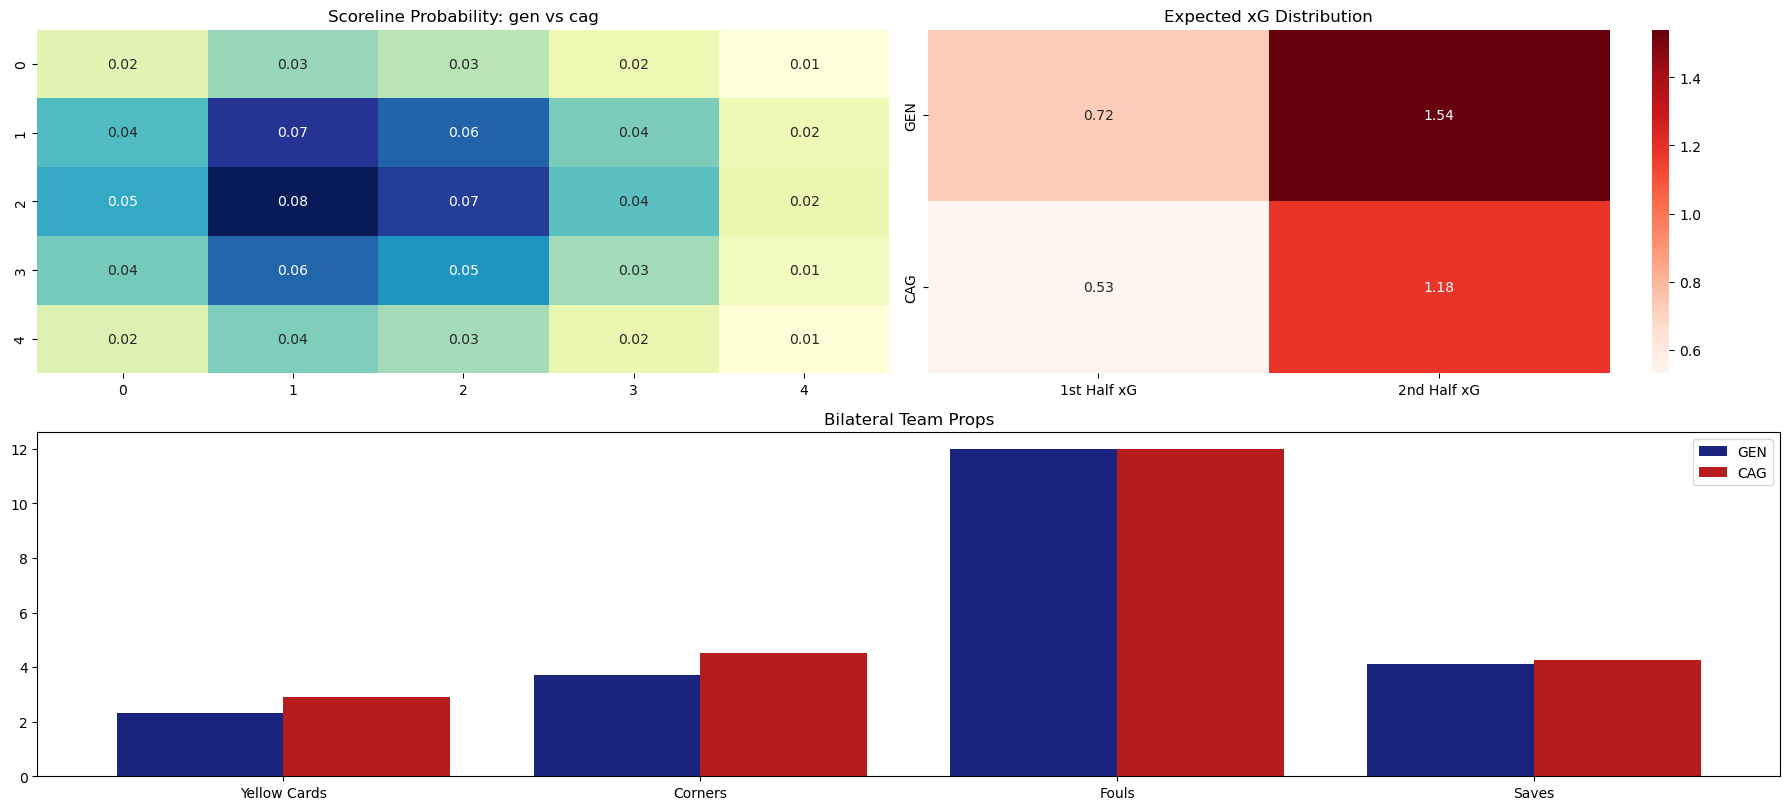

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

# ==========================================
# 1. THE "OUTLIER" FEATURE ENGINE
# ==========================================
def prepare_outlier_df(df):
    """Raw scaling without scarcity filters to find maximum market gaps."""
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'team':
            df[col] = df[col].str.replace('%', '').astype(float) / 100

    # Stronger Weighting on Recent Momentum (Last 5)
    df['adj_att'] = (df['rolling_xg_L5'] * 0.8) + (df['goals_per_90'] * 0.2)
    # Strength of Schedule as a direct multiplier (Unfiltered)
    df['adj_att'] = df['adj_att'] * df['SoS_Weight_L5']
    df['adj_def'] = df['rolling_xga_l5'] / df['SoS_Weight_L5']
    
    return df

# ==========================================
# 2. THE COMPREHENSIVE SIMULATOR
# ==========================================
def run_outlier_sim(h, a, iterations=30000):
    # Goal Expectations (Raw Multipliers - This creates the 66% outliers)
    h_exp_total = h['adj_att'] * (a['adj_def'] / 1.2) * 1.1 # Home Advantage Boost
    a_exp_total = a['adj_att'] * (h['adj_def'] / 1.2) * 0.9 # Away Disadvantage
    
    # 1st/2nd Half Splits (Direct xG Distribution)
    h_1st = h_exp_total * (1 - h['Second_Half_Goals_Ratio'])
    h_2nd = h_exp_total * h['Second_Half_Goals_Ratio']
    a_1st = a_exp_total * (1 - a['Second_Half_Goals_Ratio'])
    a_2nd = a_exp_total * a['Second_Half_Goals_Ratio']

    # Monte Carlo Simulations
    h_sims = np.random.poisson(h_exp_total, iterations)
    a_sims = np.random.poisson(a_exp_total, iterations)
    
    # Market Probabilities
    h_win = np.mean(h_sims > a_sims) * 100
    draw = np.mean(h_sims == a_sims) * 100
    a_win = np.mean(h_sims < a_sims) * 100
    btts = np.mean((h_sims > 0) & (a_sims > 0)) * 100

    # Discipline & Props (High Aggression Logic)
    ref_mod = h.get('Ref_Card_Avg', 3.8) / 3.0 # Aggressive Ref scaling
    h_yc = h['yc_per_90'] * ref_mod
    a_yc = a['yc_per_90'] * ref_mod
    
    # Corners & Saves
    h_corn = h.get('corners_per_90', 5) * (h['Field_Tilt_L5'] * 2.0)
    a_corn = a.get('corners_per_90', 4) * (a['Field_Tilt_L5'] * 2.0)
    h_saves = (a.get('shots_on_target_per_90', 4) * (1 + a['Field_Tilt_L5'])) * h.get('save_pct', 0.7)
    a_saves = (h.get('shots_on_target_per_90', 4) * (1 + h['Field_Tilt_L5'])) * a.get('save_pct', 0.7)

    # Outcome Mode
    scores = list(zip(h_sims, a_sims))
    proj_score = max(set(scores), key=scores.count)

    return {
        "wdl": [h_win, draw, a_win],
        "btts": btts,
        "proj_score": proj_score,
        "xg_split": {"h": [h_1st, h_2nd, h_exp_total], "a": [a_1st, a_2nd, a_exp_total]},
        "props": {
            "h": {"yc": h_yc, "corn": h_corn, "foul": h.get('fouls_per_90', 12), "saves": h_saves},
            "a": {"yc": a_yc, "corn": a_corn, "foul": a.get('fouls_per_90', 12), "saves": a_saves}
        },
        "half_probs": {
            "h_fh": (1 - np.exp(-h_1st)) * 100, "a_fh": (1 - np.exp(-a_1st)) * 100,
            "total_fh": (1 - np.exp(-(h_1st + a_1st))) * 100,
            "total_sh": (1 - np.exp(-(h_2nd + a_2nd))) * 100
        }
    }

# ==========================================
# 3. COMPREHENSIVE DASHBOARD (Heatmaps + Props)
# ==========================================
def plot_full_report(res, h_id, a_id):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Scoreline Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    matrix = np.outer(poisson.pmf(range(5), res['xg_split']['h'][2]), poisson.pmf(range(5), res['xg_split']['a'][2]))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax1, cbar=False)
    ax1.set_title(f"Scoreline Probability: {h_id} vs {a_id}")

    # B. Half-by-Half xG Intensity
    ax2 = fig.add_subplot(gs[0, 1])
    timing_data = [[res['xg_split']['h'][0], res['xg_split']['h'][1]], [res['xg_split']['a'][0], res['xg_split']['a'][1]]]
    sns.heatmap(timing_data, annot=True, fmt=".2f", cmap="Reds", ax=ax2, 
                xticklabels=['1st Half xG', '2nd Half xG'], yticklabels=[h_id.upper(), a_id.upper()])
    ax2.set_title("Expected xG Distribution")

    # C. Multi-Prop Comparison
    ax3 = fig.add_subplot(gs[1, :])
    metrics = ['Yellow Cards', 'Corners', 'Fouls', 'Saves']
    h_m = [res['props']['h']['yc'], res['props']['h']['corn'], res['props']['h']['foul'], res['props']['h']['saves']]
    a_m = [res['props']['a']['yc'], res['props']['a']['corn'], res['props']['a']['foul'], res['props']['a']['saves']]
    x = np.arange(len(metrics))
    ax3.bar(x - 0.2, h_m, 0.4, label=h_id.upper(), color='#1a237e')
    ax3.bar(x + 0.2, a_m, 0.4, label=a_id.upper(), color='#b71c1c')
    ax3.set_xticks(x); ax3.set_xticklabels(metrics); ax3.legend()
    ax3.set_title("Bilateral Team Props")

    plt.tight_layout()
    plt.show()

# ==========================================
# 4. EXECUTION
# ==========================================
# Load and run
df = prepare_outlier_df(pd.read_csv('gen_cag.csv'))
h_id, a_id = 'gen', 'cag' # Set your teams here
results = run_outlier_sim(df[df['team']==h_id].iloc[0], df[df['team']==a_id].iloc[0])

# --- FINAL OUTPUT ---
print(f"\n{'='*50}\n {h_id.upper()} vs {a_id.upper()} OUTLIER REPORT\n{'='*50}")
print(f"PROJECTED SCORE:   {results['proj_score'][0]} - {results['proj_score'][1]}")
print(f"W/D/L CHANCE:      {h_id}: {results['wdl'][0]:.1f}% | Draw: {results['wdl'][1]:.1f}% | {a_id}: {results['wdl'][2]:.1f}%")
print(f"BTTS CHANCE:       {results['btts']:.1f}%")
print(f"1st HALF GOAL %:   Total: {results['half_probs']['total_fh']:.1f}% ({h_id}: {results['half_probs']['h_fh']:.1f}% | {a_id}: {results['half_probs']['a_fh']:.1f}%)")
print(f"2nd HALF GOAL %:   Total: {results['half_probs']['total_sh']:.1f}%")
print("-" * 50)
print(f"SAVES:             {h_id}: {results['props']['h']['saves']:.1f} | {a_id}: {results['props']['a']['saves']:.1f}")
print(f"YELLOW CARDS:      {h_id}: {results['props']['h']['yc']:.1f} | {a_id}: {results['props']['a']['yc']:.1f}")
print(f"CORNERS:           {h_id}: {results['props']['h']['corn']:.1f} | {a_id}: {results['props']['a']['corn']:.1f}")
print("-" * 50)
print(f"TEAM xG:           {h_id}: {results['xg_split']['h'][2]:.2f} | {a_id}: {results['xg_split']['a'][2]:.2f}")

plot_full_report(results, h_id, a_id)